In [26]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, Angle
from astropy.coordinates import SkyCoord as sc
import pandas
import warnings 
import copy
from hera_notebook_templates import utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
from IPython.display import display, HTML
from scipy.signal import find_peaks
#warnings.filterwarnings('ignore')

from ipywidgets import interact
import ffmpeg
import ipywidgets as widgets

from scipy import signal
from numpy.fft import ifft
from numpy.random import default_rng

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
display(HTML("<style>.container { width:100% !important; }</style>"))

ModuleNotFoundError: No module named 'ffmpeg'

In [3]:
def generate_nodeDict_allPols(uv,pol='E'):
    """
    Generates dictionaries containing node and antenna information.
    
    Parameters:
    ----------
    uv: UVData Object
        Sample observation to extract node and antenna information from.
    
    Returns:
    -------
    nodes: Dict
        Dictionary containing entry for all nodes, each of which has keys: 'ants', 'snapLocs', 'snapInput'.
    antDict: Dict
        Dictionary containing entry for all antennas, each of which has keys: 'node', 'snapLocs', 'snapInput'.
    inclNodes: List
        Nodes that have hooked up antennas.
    """
    
    antnums = uv.get_ants()
    h = cm_hookup.Hookup()
    x = h.get_hookup('HH')
    nodes = {}
    antDict = {}
    inclNodes = []
    for ant in antnums:
        key = 'HH%i:A' % (ant)
        n = x[key].get_part_from_type('node')[f'{pol}<ground']
        if n is None:
            continue
        else:
            n = n[1:]
        snapLoc = (x[key].hookup[f'{pol}<ground'][-1].downstream_input_port[-1], ant)
        snapInput = (x[key].hookup[f'{pol}<ground'][-2].downstream_input_port[1:], ant)
        antDict[ant] = {}
        antDict[ant]['node'] = str(n)
        antDict[ant]['snapLocs'] = snapLoc
        antDict[ant]['snapInput'] = snapInput
        inclNodes.append(n)
        if n in nodes:
            nodes[n]['ants'].append(ant)
            nodes[n]['snapLocs'].append(snapLoc)
            nodes[n]['snapInput'].append(snapInput)
        else:
            nodes[n] = {}
            nodes[n]['ants'] = [ant]
            nodes[n]['snapLocs'] = [snapLoc]
            nodes[n]['snapInput'] = [snapInput]
    inclNodes = np.unique(inclNodes)
    return nodes, antDict, inclNodes

In [4]:
def plot_ants (JD, root, *ants):
    
    data_path = root + str(JD)
    ant_metrics_ext = ".known_good.ant_metrics.hdf5"
    statuses = 'RF_ok,digital_ok,digital_maintenance,calibration_ok,RF_maintenance'
    utc = Time(JD, format='jd').datetime
    print(f'JD = {JD}')
    print(f'Date = {utc.month}-{utc.day}-{utc.year}')
    print(f'data_path = "{data_path}"')
    
    HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    print (len(HHfiles[0].split('.')))
    print (len(HHfiles))
    print (HHfiles[0].split('.'))
    
    uvd = UVData()
    unread = True
    readInd=0
    while unread and readInd<len(HHautos):
        try:
            uvd.read(HHautos[readInd])
            unread = False
        except:
            readInd += 1
            continue
    use_ants = utils.get_use_ants(uvd,statuses,JD)
    print(f'This day contains {len(use_ants)} antennas of the given status category.')
    uvd.read(HHautos[::10], skip_bad_files=True, antenna_nums = use_ants)
    lsts = uvd.lst_array
    uvdx.select(antenna_nums=use_ants)
    uvdy.select(antenna_nums=use_ants)
    
    for i in range(len(ants)):
        #print(clocks1)
        # print((-np.average(data1, axis=0)).argsort()[:3])
        fig, ax = plt.subplots(4 , 1, figsize = (15,25))

        #ax = axes[0, 0]

        data1 = uvd.get_data(ants[i],ants[i],'XX')
        data2 = uvd.get_data(ants[i],ants[i],'YY')
        freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

        data1_avg = np.average(data1, axis=0)
        data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
        data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
        data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
        data2_avg = np.average(data2, axis=0)
        data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
        data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
        data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
        peaks1, _ = find_peaks(data1_avg[0:384], distance=40)
        peaks2, _ = find_peaks(data2_avg[0:384], distance=40)
        ax[0].plot(freq[0:384],data1_avg[0:384], label = 'XX', alpha = .75)
        ax[0].plot(freq[0:384],data2_avg[0:384], label = 'YY', alpha = .75)
        ax[0].legend()

        axmin, axmax = ax[0].get_ylim()
        number = [49.97253418, 69.97253418, 89.97253418, 82]

        for a in range(len(number)):
            ax[0].vlines(number[a], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)

        ax[0].set_title(f'First Quarter of Antenna {ants[i]}')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(f'Frequency (MHz)')


        peaks3, _ = find_peaks(data1_avg[0:768], distance=40)
        peaks4, _ = find_peaks(data2_avg[0:768], distance=40)
        ax[1].plot(freq[0:768],data1_avg[0:768], label = 'XX', alpha = .75)
        ax[1].plot(freq[0:768],data2_avg[0:768], label = 'YY', alpha = .75)
        ax[1].legend()
        
        ax[1].set_title(f'First half of Antenna {ants[i]}')
        ax[1].set_yscale('log')
        ax[1].set_xlabel(f'Frequency (MHz)')

        
        axmin, axmax = ax[1].get_ylim()
        number = [49.97253418, 69.97253418, 89.97253418, 82, 102, 122]

        for a in range(len(number)):
            ax[1].vlines(number[a], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)


        peaks5, _ = find_peaks(data1_avg[768:1536], distance=40)
        peaks6, _ = find_peaks(data2_avg[768:1536], distance=40)
        ax[2].plot(freq[768:1536],data1_avg[768:1536], label = 'XX', alpha = .75)
        #ax[2].plot(freq[peaks5],data1_avg[peaks5],"xr")
        ax[2].plot(freq[768:1536],data2_avg[768:1536], label = 'YY', alpha = .75)
        #ax[2].plot(freq[peaks6],data2_avg[peaks6],"xr")
        ax[2].legend()
        
        ax[2].set_title(f'Second half of Antenna {ants[i]}')
        ax[2].set_yscale('log')
        ax[2].set_xlabel(f'Frequency (MHz)')

    #     axmin, axmax = ax[2].get_ylim()
    #     number = [47.04284668, 66.8182373, 93.55163574, 82, 102, 122]

    #     for i in range(len(number)):
    #         ax[2].vlines(number[i], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)


        peaks7, _ = find_peaks(data1_avg, distance=40)
        peaks8, _ = find_peaks(data2_avg, distance=40)
        ax[3].plot(freq,data1_avg, label = 'XX', alpha = .75)
        ax[3].plot(freq,data2_avg, label = 'YY', alpha = .75)
        ax[3].legend()

        axmin, axmax = ax[3].get_ylim()


        ax[3].set_title(f'Full Sprectrum of Antenna {ants[i]}')
        ax[3].set_yscale('log')
        ax[3].set_xlabel(f'Frequency (MHz)')

In [9]:
def plot_node(JD, root, node):
    
    data_path = root + str(JD)
    ant_metrics_ext = ".known_good.ant_metrics.hdf5"
    statuses = 'RF_ok,digital_ok,digital_maintenance,calibration_ok,RF_maintenance'
    utc = Time(JD, format='jd').datetime
    print(f'JD = {JD}')
    print(f'Date = {utc.month}-{utc.day}-{utc.year}')
    print(f'data_path = "{data_path}"')
    
    HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    
    uvd = UVData()
    unread = True
    readInd=0
    while unread and readInd<len(HHautos):
        try:
            uvd.read(HHautos[readInd])
            unread = False
        except:
            readInd += 1
            continue
    use_ants = utils.get_use_ants(uvd,statuses,JD)
    print(f'This day contains {len(use_ants)} antennas of the given status category.')
    uvd.read(HHautos[::10], skip_bad_files=True, antenna_nums = use_ants)
    lsts = uvd.lst_array
    uvdx.select(antenna_nums=use_ants)
    uvdy.select(antenna_nums=use_ants)
    
    nodeDict, _, _ = generate_nodeDict_allPols(uvd)

    ants_in_node = nodeDict[node]['ants']
    
    print (f"There are {len(ants_in_node)} antennas in this node. They are {ants_in_node}")
    
    for i in range(len(ants_in_node)):
        #print(clocks1)
        # print((-np.average(data1, axis=0)).argsort()[:3])
        fig, ax = plt.subplots(4 , 1, figsize = (15,25))

        #ax = axes[0, 0]

        data1 = uvd.get_data(ants_in_node[i],ants_in_node[i],'XX')
        data2 = uvd.get_data(ants_in_node[i],ants_in_node[i],'YY')
        freq = uvd.freq_array[0]*1e-6 #converted to MegaHz

        data1_avg = np.average(data1, axis=0)
        data1_avg[128] = (data1_avg[127] + data1_avg[129])/2
        data1_avg[1152] = (data1_avg[1151] + data1_avg[1153])/2
        data1_avg[640] = (data1_avg[639] + data1_avg[641])/2
        data2_avg = np.average(data2, axis=0)
        data2_avg[128] = (data2_avg[127] + data2_avg[129])/2
        data2_avg[1152] = (data2_avg[1151] + data2_avg[1153])/2
        data2_avg[640] = (data2_avg[639] + data2_avg[641])/2
        peaks1, _ = find_peaks(data1_avg[0:384], distance=40)
        peaks2, _ = find_peaks(data2_avg[0:384], distance=40)
        ax[0].plot(freq[0:384],data1_avg[0:384], label = 'XX', alpha = .75)
        ax[0].plot(freq[0:384],data2_avg[0:384], label = 'YY', alpha = .75)
        ax[0].legend()

    #     axmin, axmax = ax[0,0].get_ylim()

        axmin, axmax = ax[0].get_ylim()
        number = [49.97253418, 69.97253418, 89.97253418, 82]

        for a in range(len(number)):
            ax[0].vlines(number[a], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)

        ax[0].set_title(f'First Quarter of Antenna {ants_in_node[i]}')
        ax[0].set_yscale('log')
        ax[0].set_xlabel(f'Frequency (MHz)')

        
        peaks3, _ = find_peaks(data1_avg[0:768], distance=40)
        peaks4, _ = find_peaks(data2_avg[0:768], distance=40)
        ax[1].plot(freq[0:768],data1_avg[0:768], label = 'XX', alpha = .75)
        ax[1].plot(freq[0:768],data2_avg[0:768], label = 'YY', alpha = .75)
        ax[1].legend()
        
        ax[1].set_title(f'First half of Antenna {ants_in_node[i]}')
        ax[1].set_yscale('log')
        ax[1].set_xlabel(f'Frequency (MHz)')

        
        axmin, axmax = ax[1].get_ylim()
        number = [49.97253418, 69.97253418, 89.97253418, 82, 102, 122]

        for a in range(len(number)):
            ax[1].vlines(number[a], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)


        peaks5, _ = find_peaks(data1_avg[768:1536], distance=40)
        peaks6, _ = find_peaks(data2_avg[768:1536], distance=40)
        ax[2].plot(freq[768:1536],data1_avg[768:1536], label = 'XX', alpha = .75)
        #ax[2].plot(freq[peaks5],data1_avg[peaks5],"xr")
        ax[2].plot(freq[768:1536],data2_avg[768:1536], label = 'YY', alpha = .75)
        #ax[2].plot(freq[peaks6],data2_avg[peaks6],"xr")
        ax[2].legend()
        
        ax[2].set_title(f'Second half of Antenna {ants_in_node[i]}')
        ax[2].set_yscale('log')
        ax[2].set_xlabel(f'Frequency (MHz)')

    #     axmin, axmax = ax[2].get_ylim()
    #     number = [47.04284668, 66.8182373, 93.55163574, 82, 102, 122]

    #     for i in range(len(number)):
    #         ax[2].vlines(number[i], ymin = 0, ymax = axmax, color = 'k', ls = '--', alpha = 0.5)


        peaks7, _ = find_peaks(data1_avg, distance=40)
        peaks8, _ = find_peaks(data2_avg, distance=40)
        ax[3].plot(freq,data1_avg, label = 'XX', alpha = .75)
        ax[3].plot(freq,data2_avg, label = 'YY', alpha = .75)
        ax[3].legend()

        axmin, axmax = ax[3].get_ylim()


        ax[3].set_title(f'Full Sprectrum of Antenna {ants_in_node[i]}')
        ax[3].set_yscale('log')
        ax[3].set_xlabel(f'Frequency (MHz)')


JD = 2459144
Date = 10-21-2020
data_path = "/lustre/aoc/projects/hera/lberkhou/2459144"
1862 sum files found between JDs 2459144.25108 and 2459144.66738
1862 diff files found between JDs 2459144.25108 and 2459144.66738
1862 sum auto files found between JDs 2459144.25108 and 2459144.66738
1862 diff auto files found between JDs 2459144.25108 and 2459144.66738
This day contains 71 antennas of the given status category.
There are 12 antennas in this node. They are [81, 82, 83, 98, 99, 100, 116, 117, 118, 119, 137, 138]


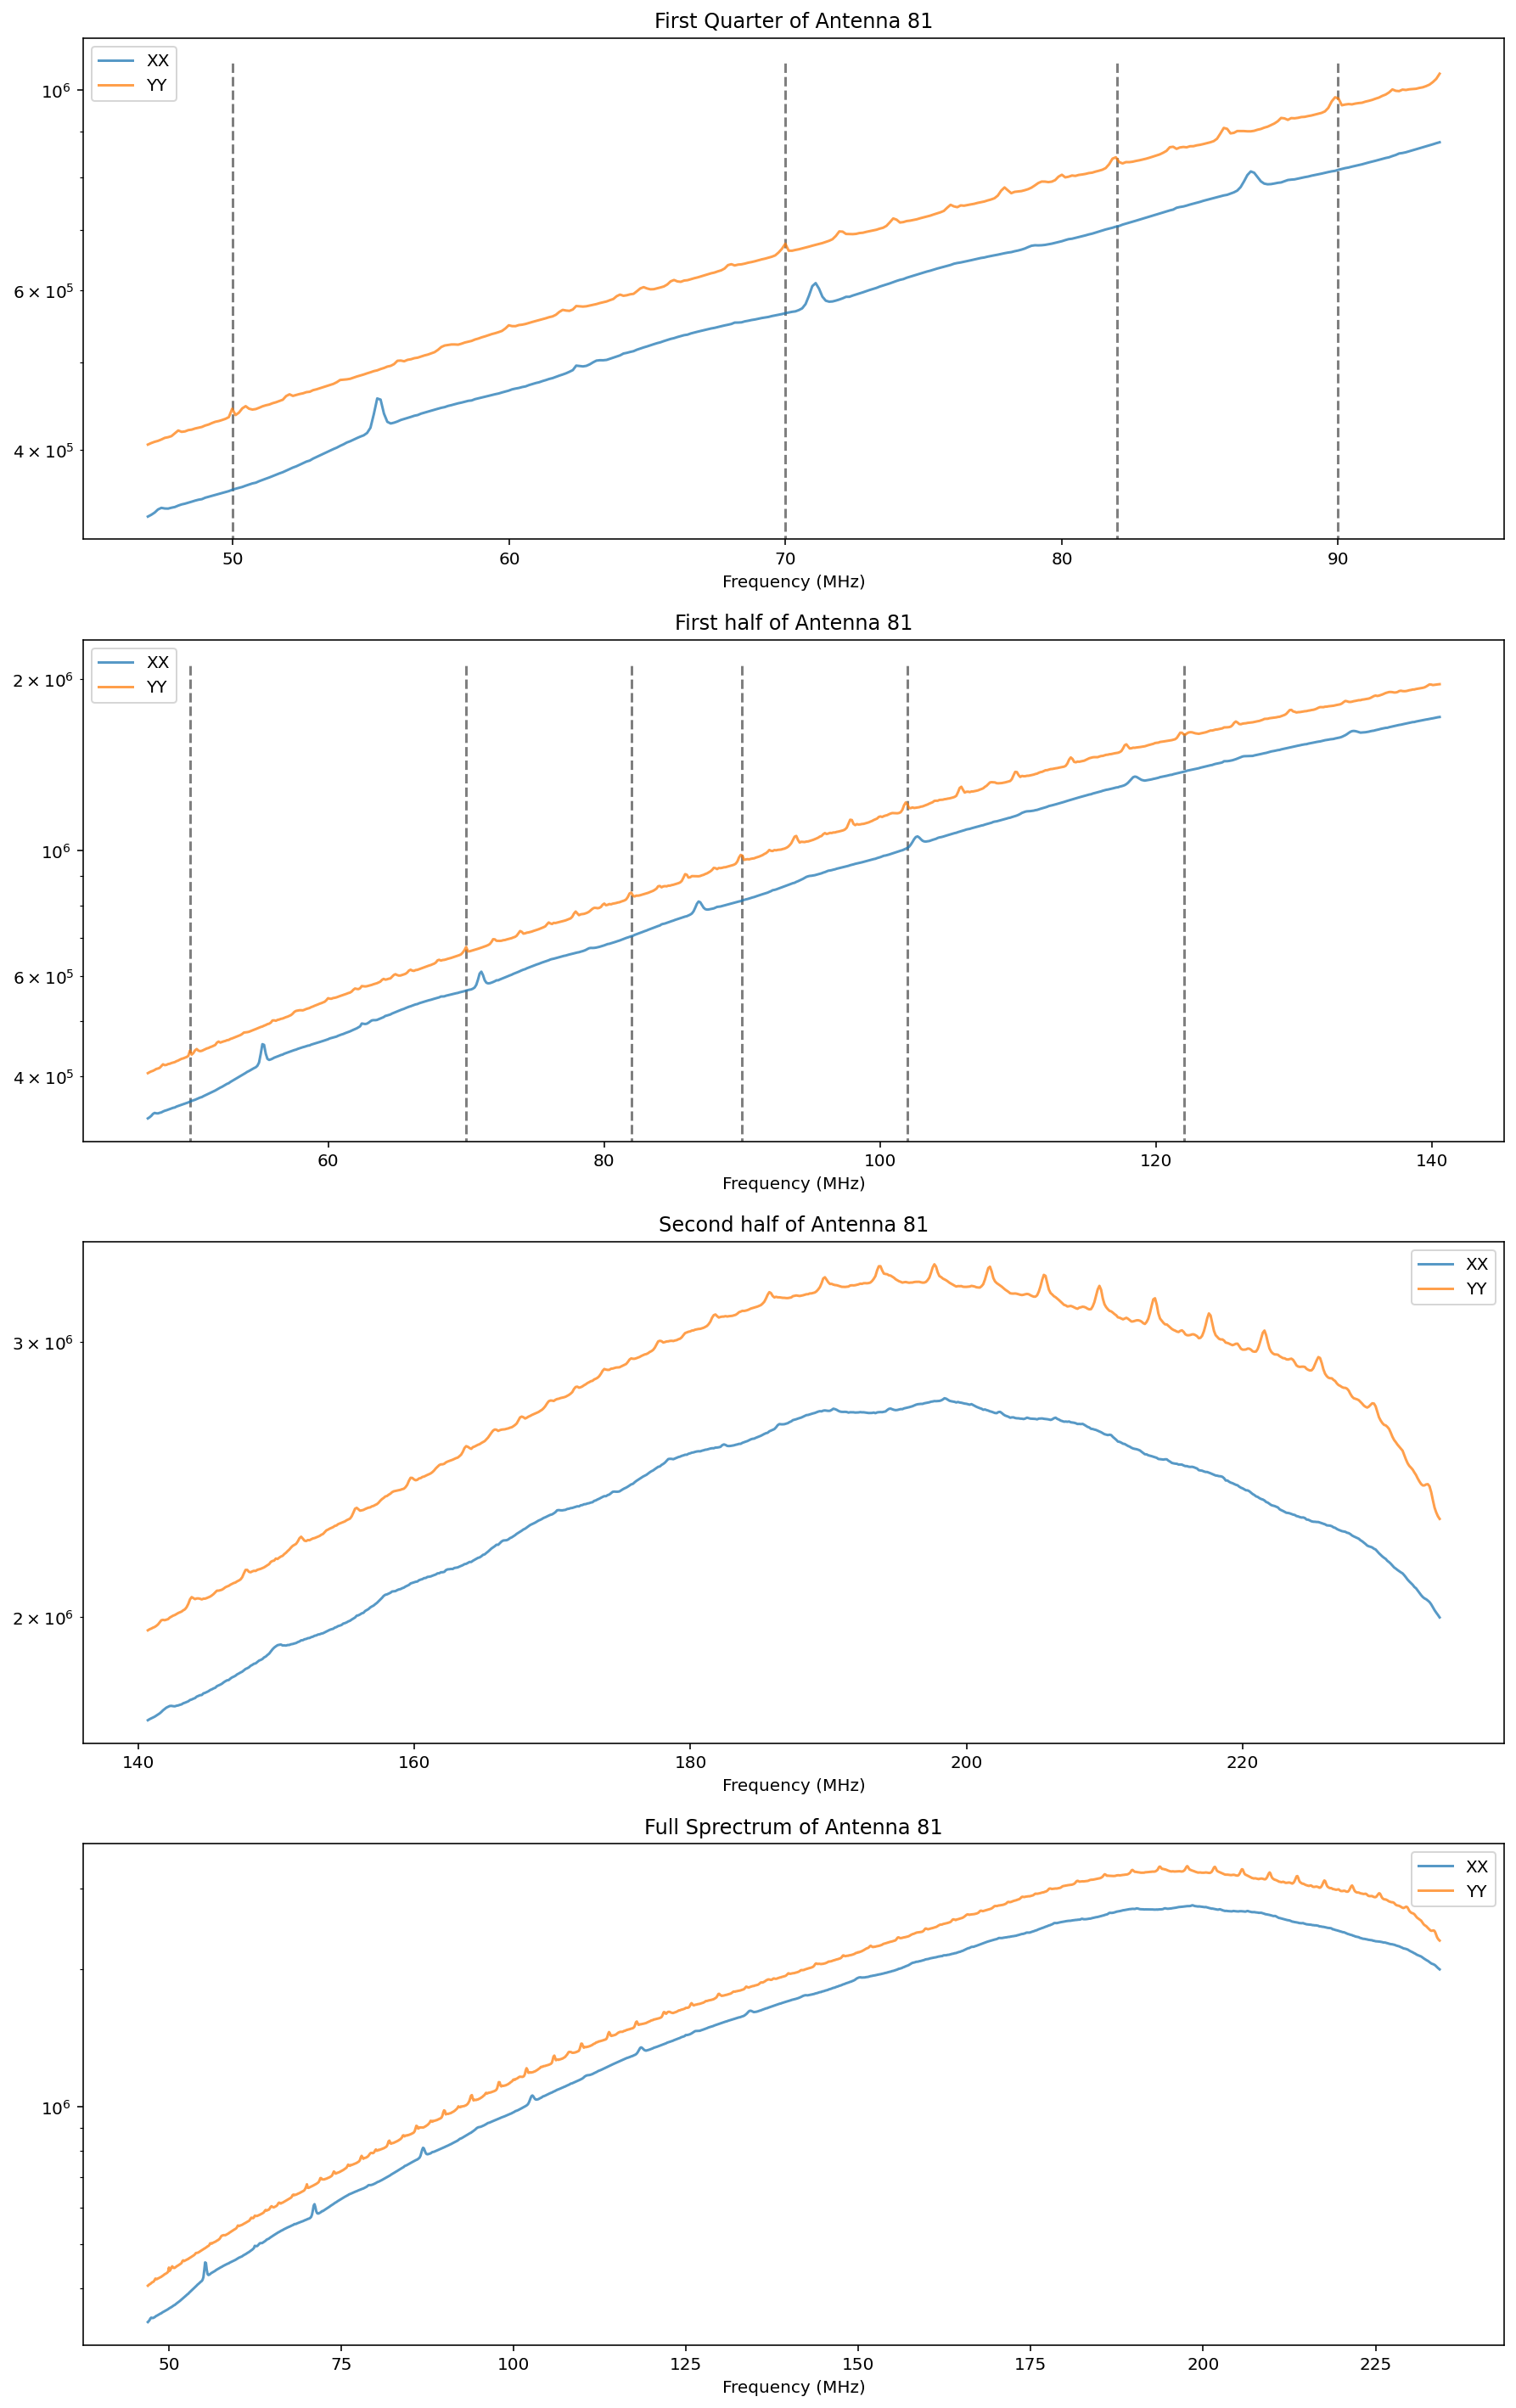

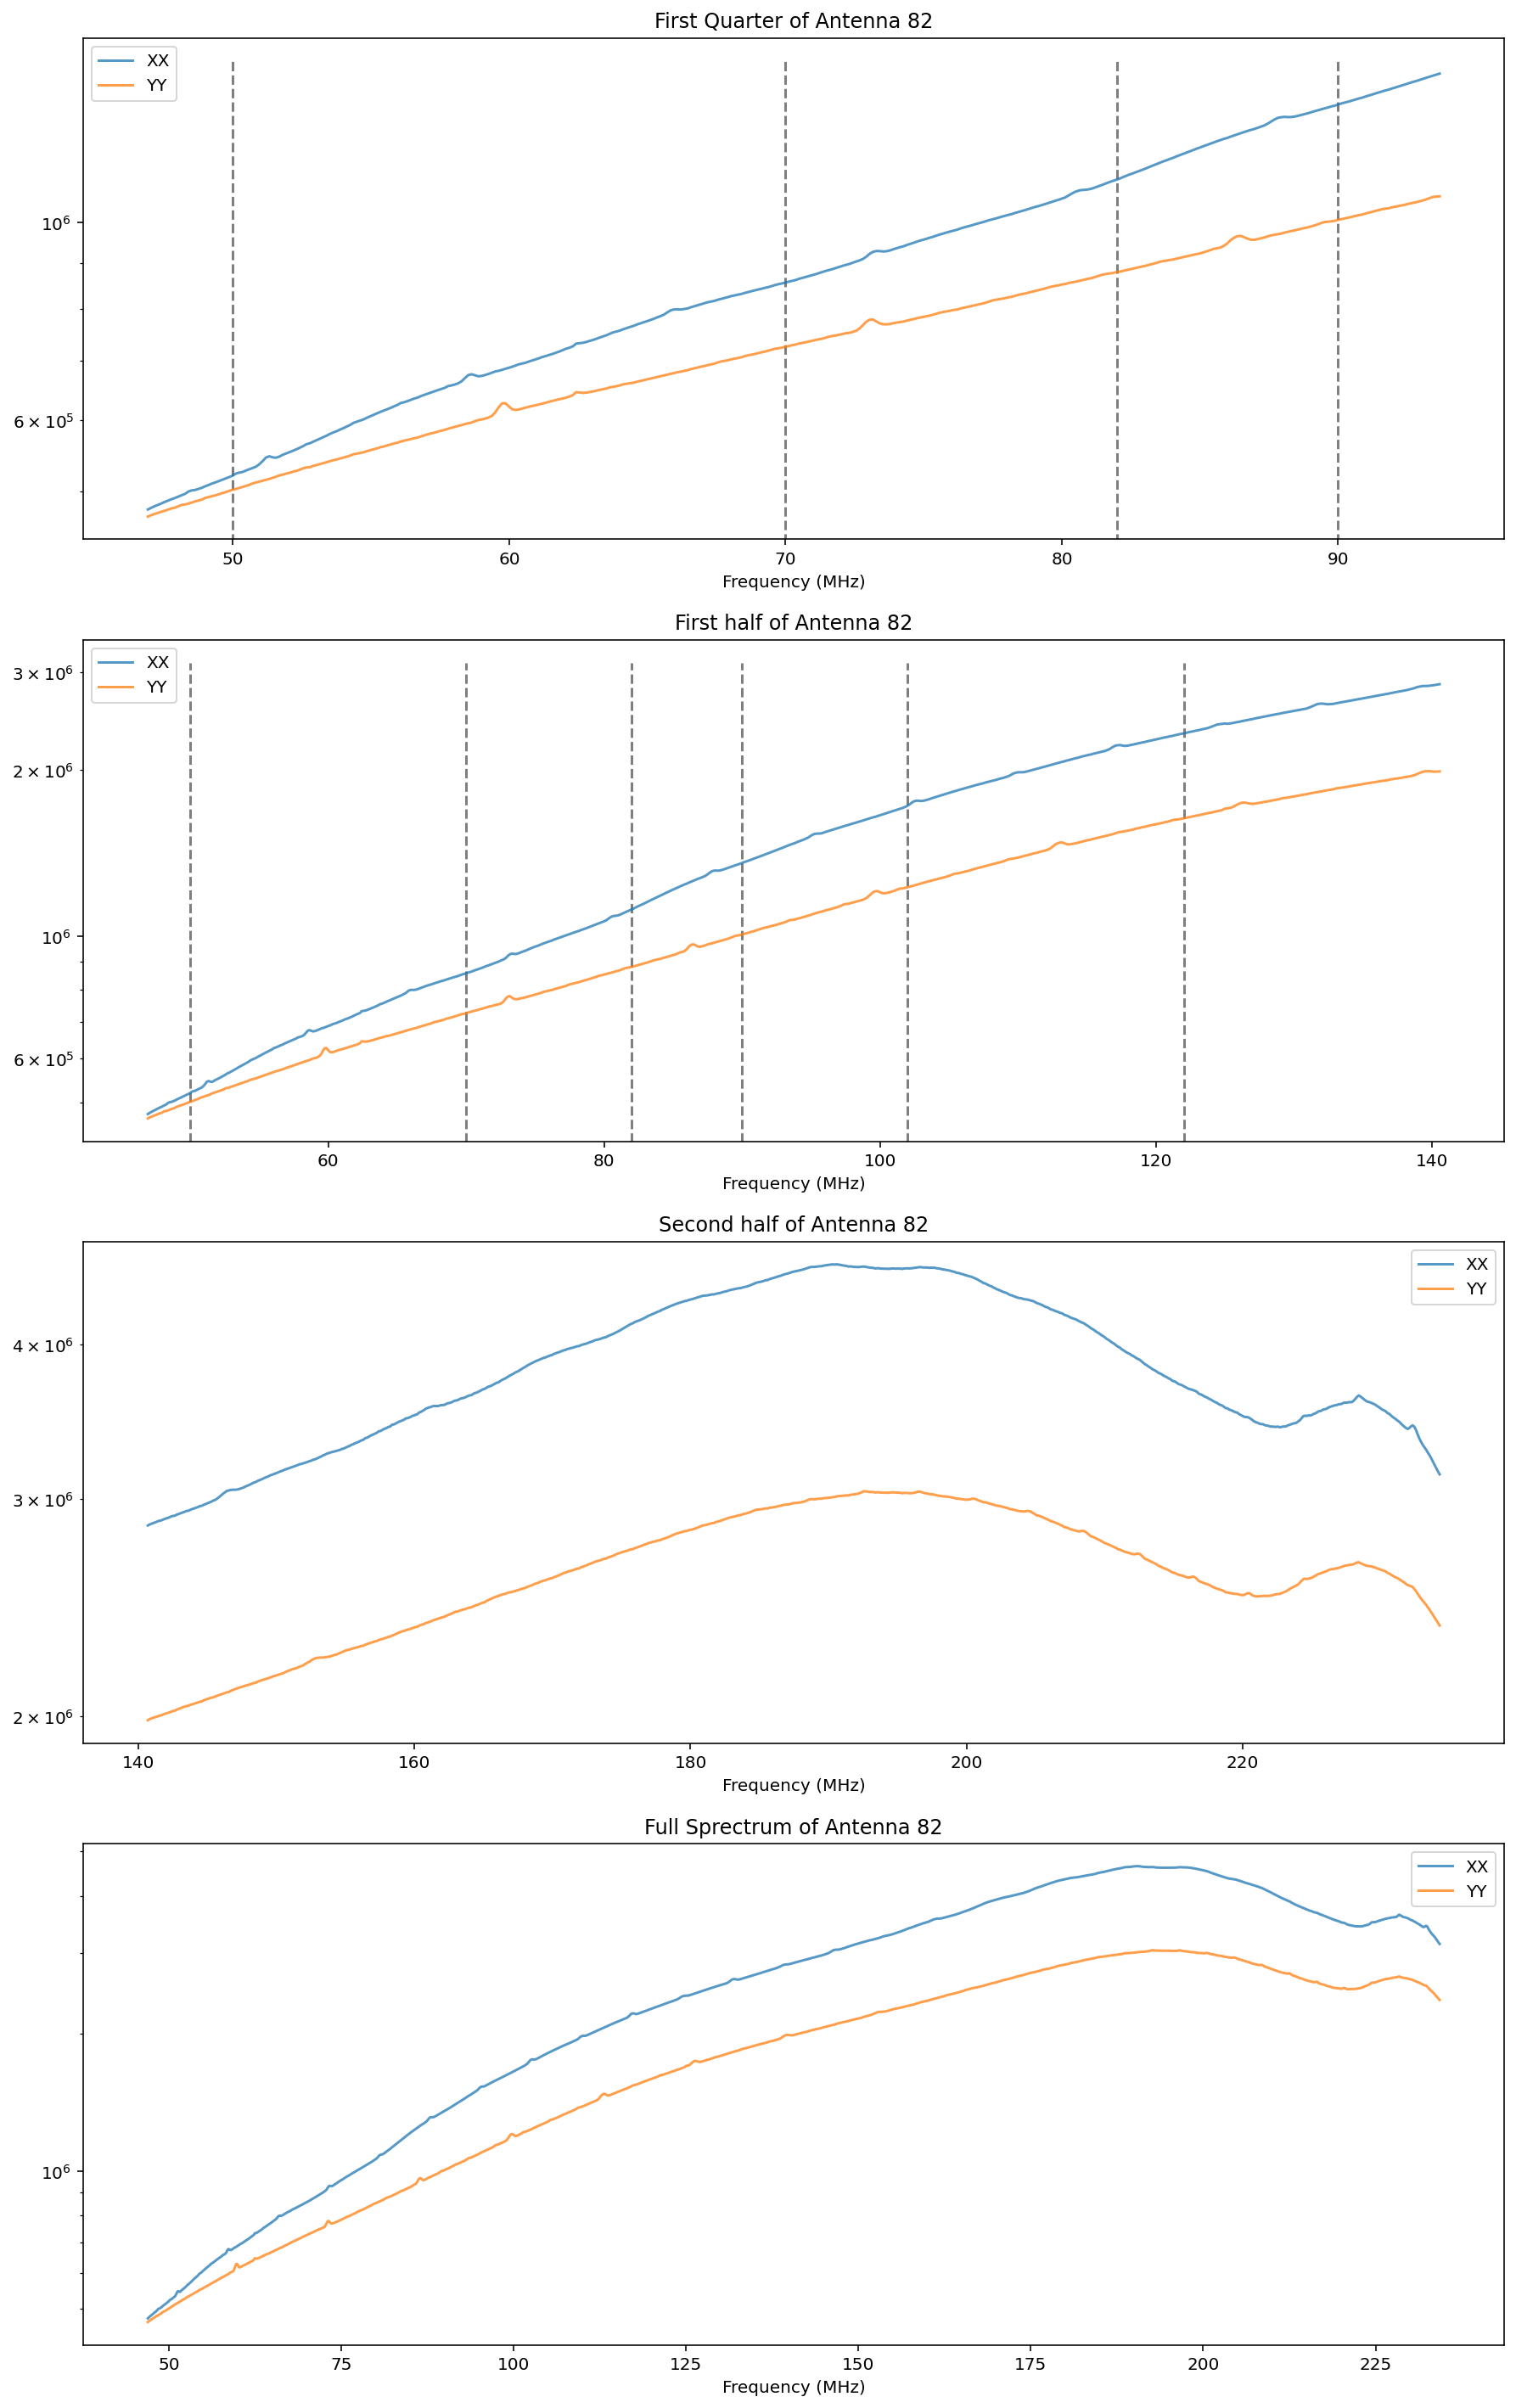

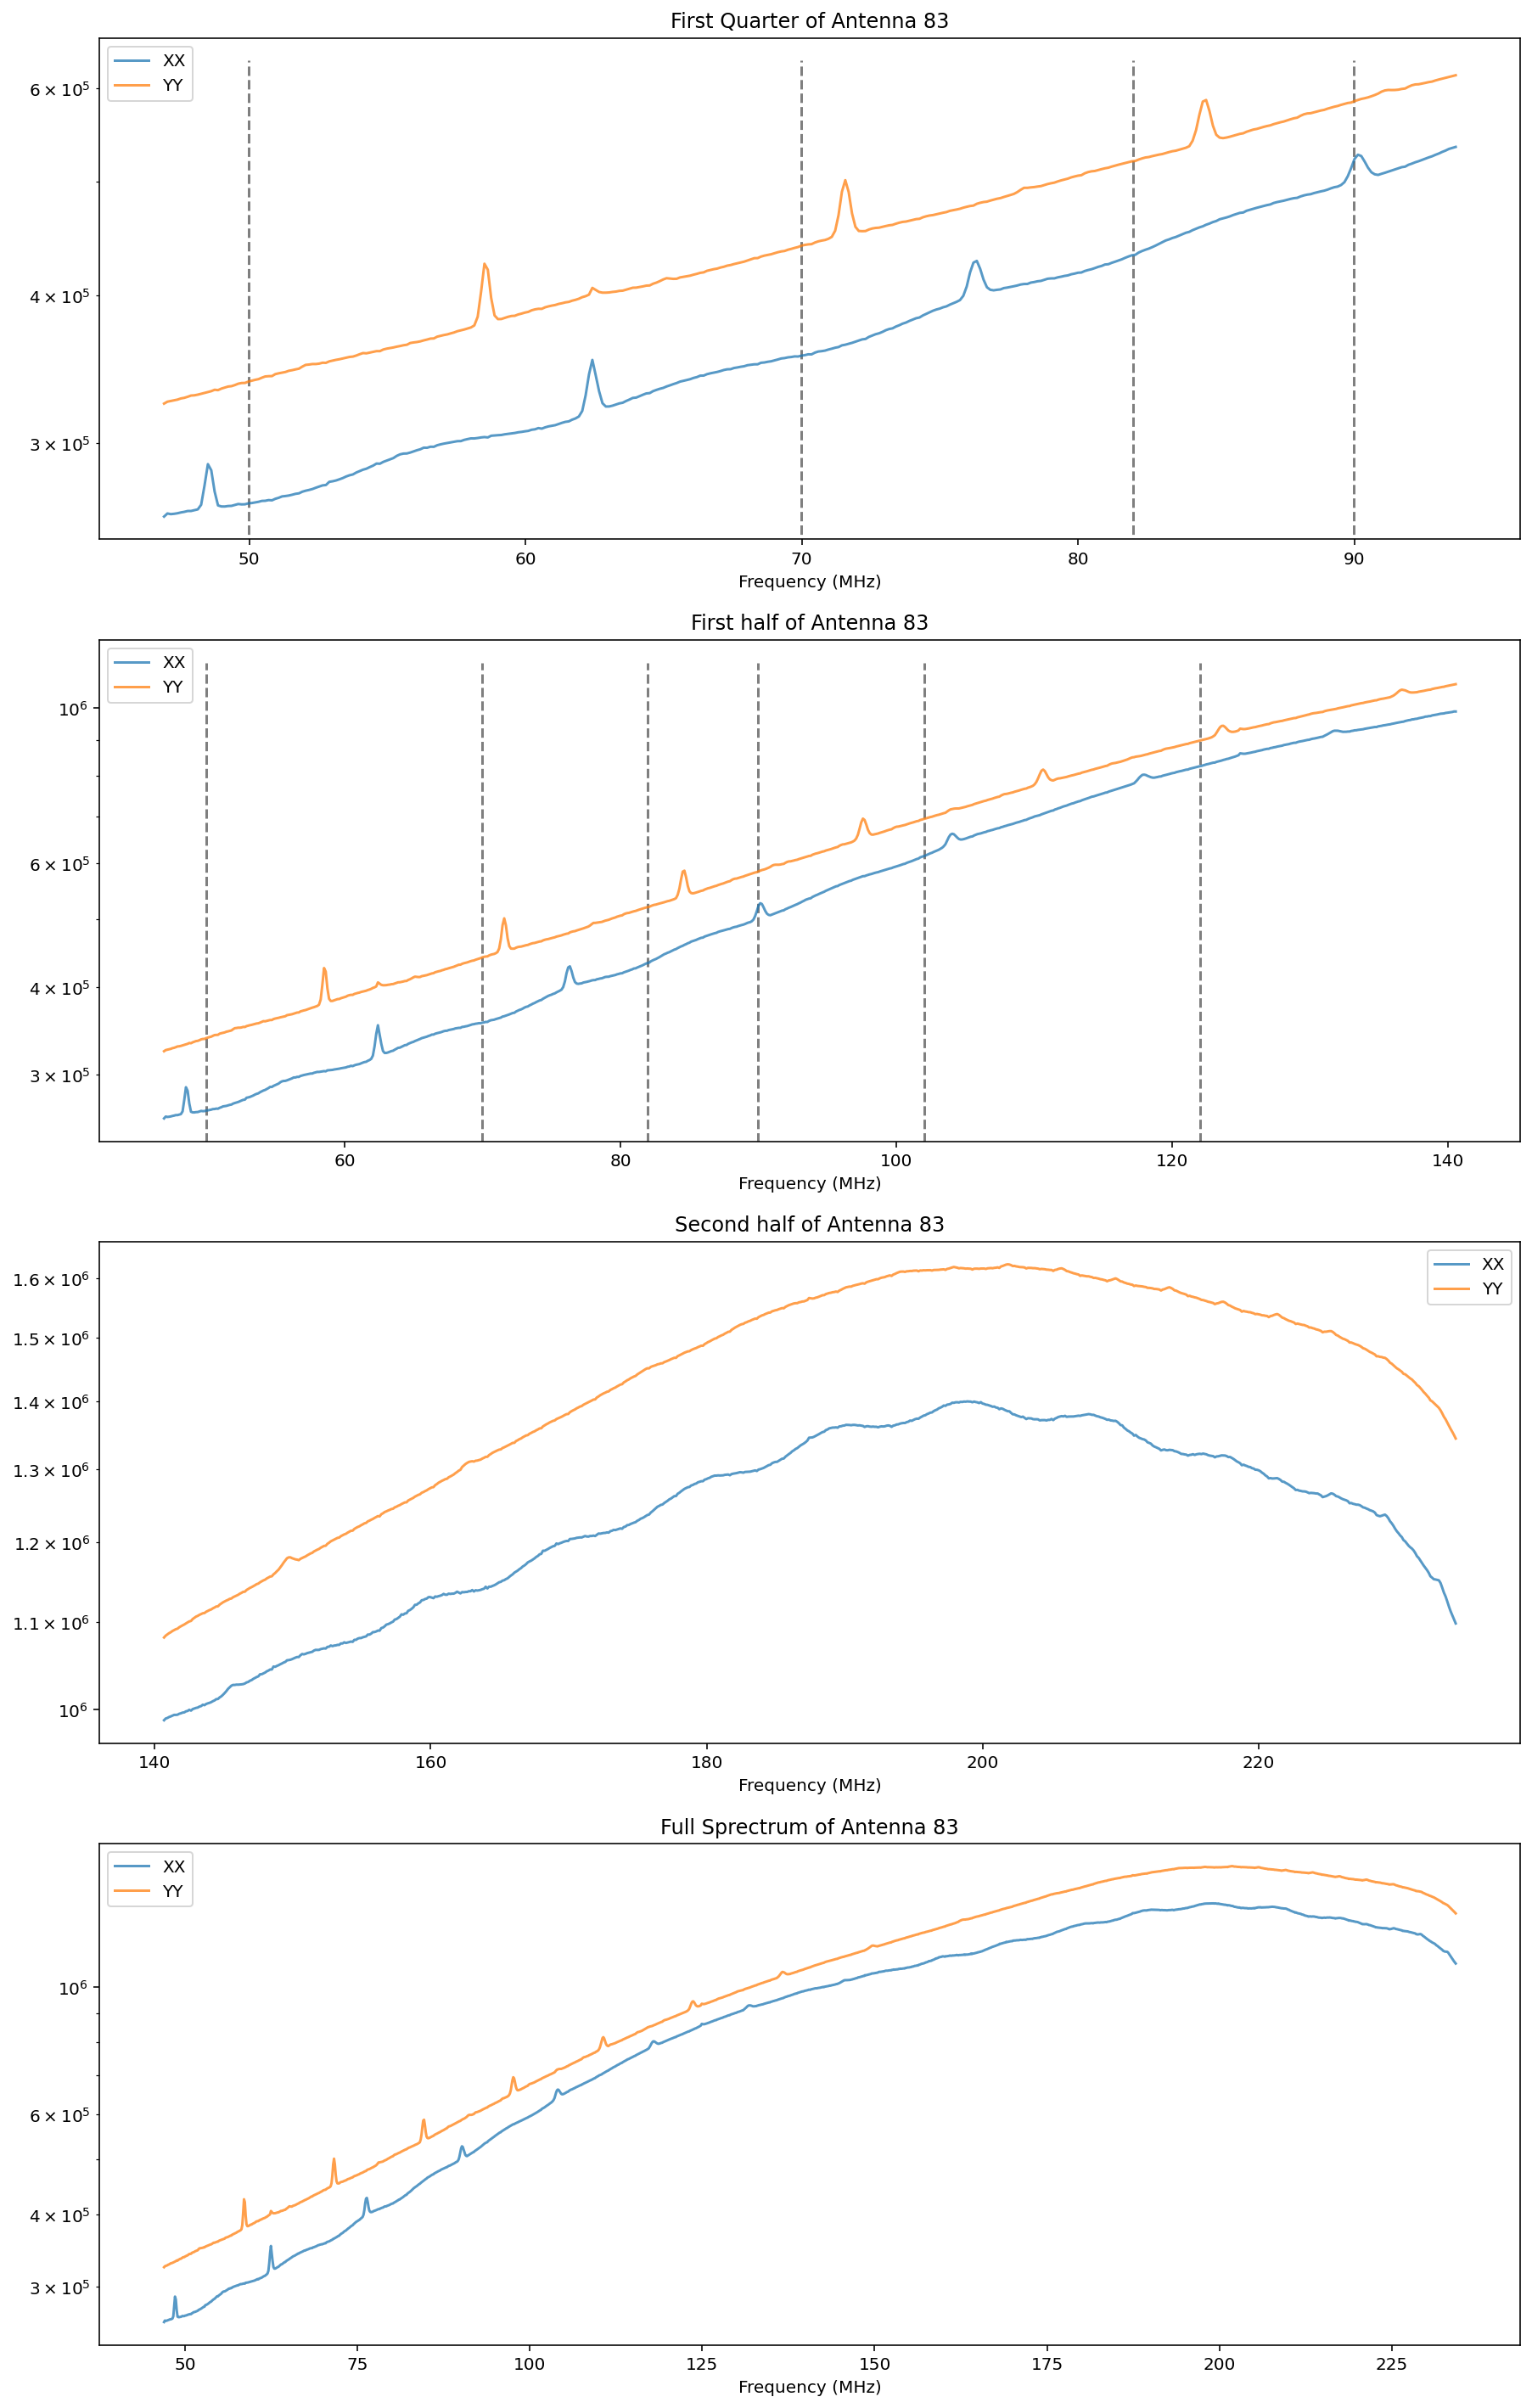

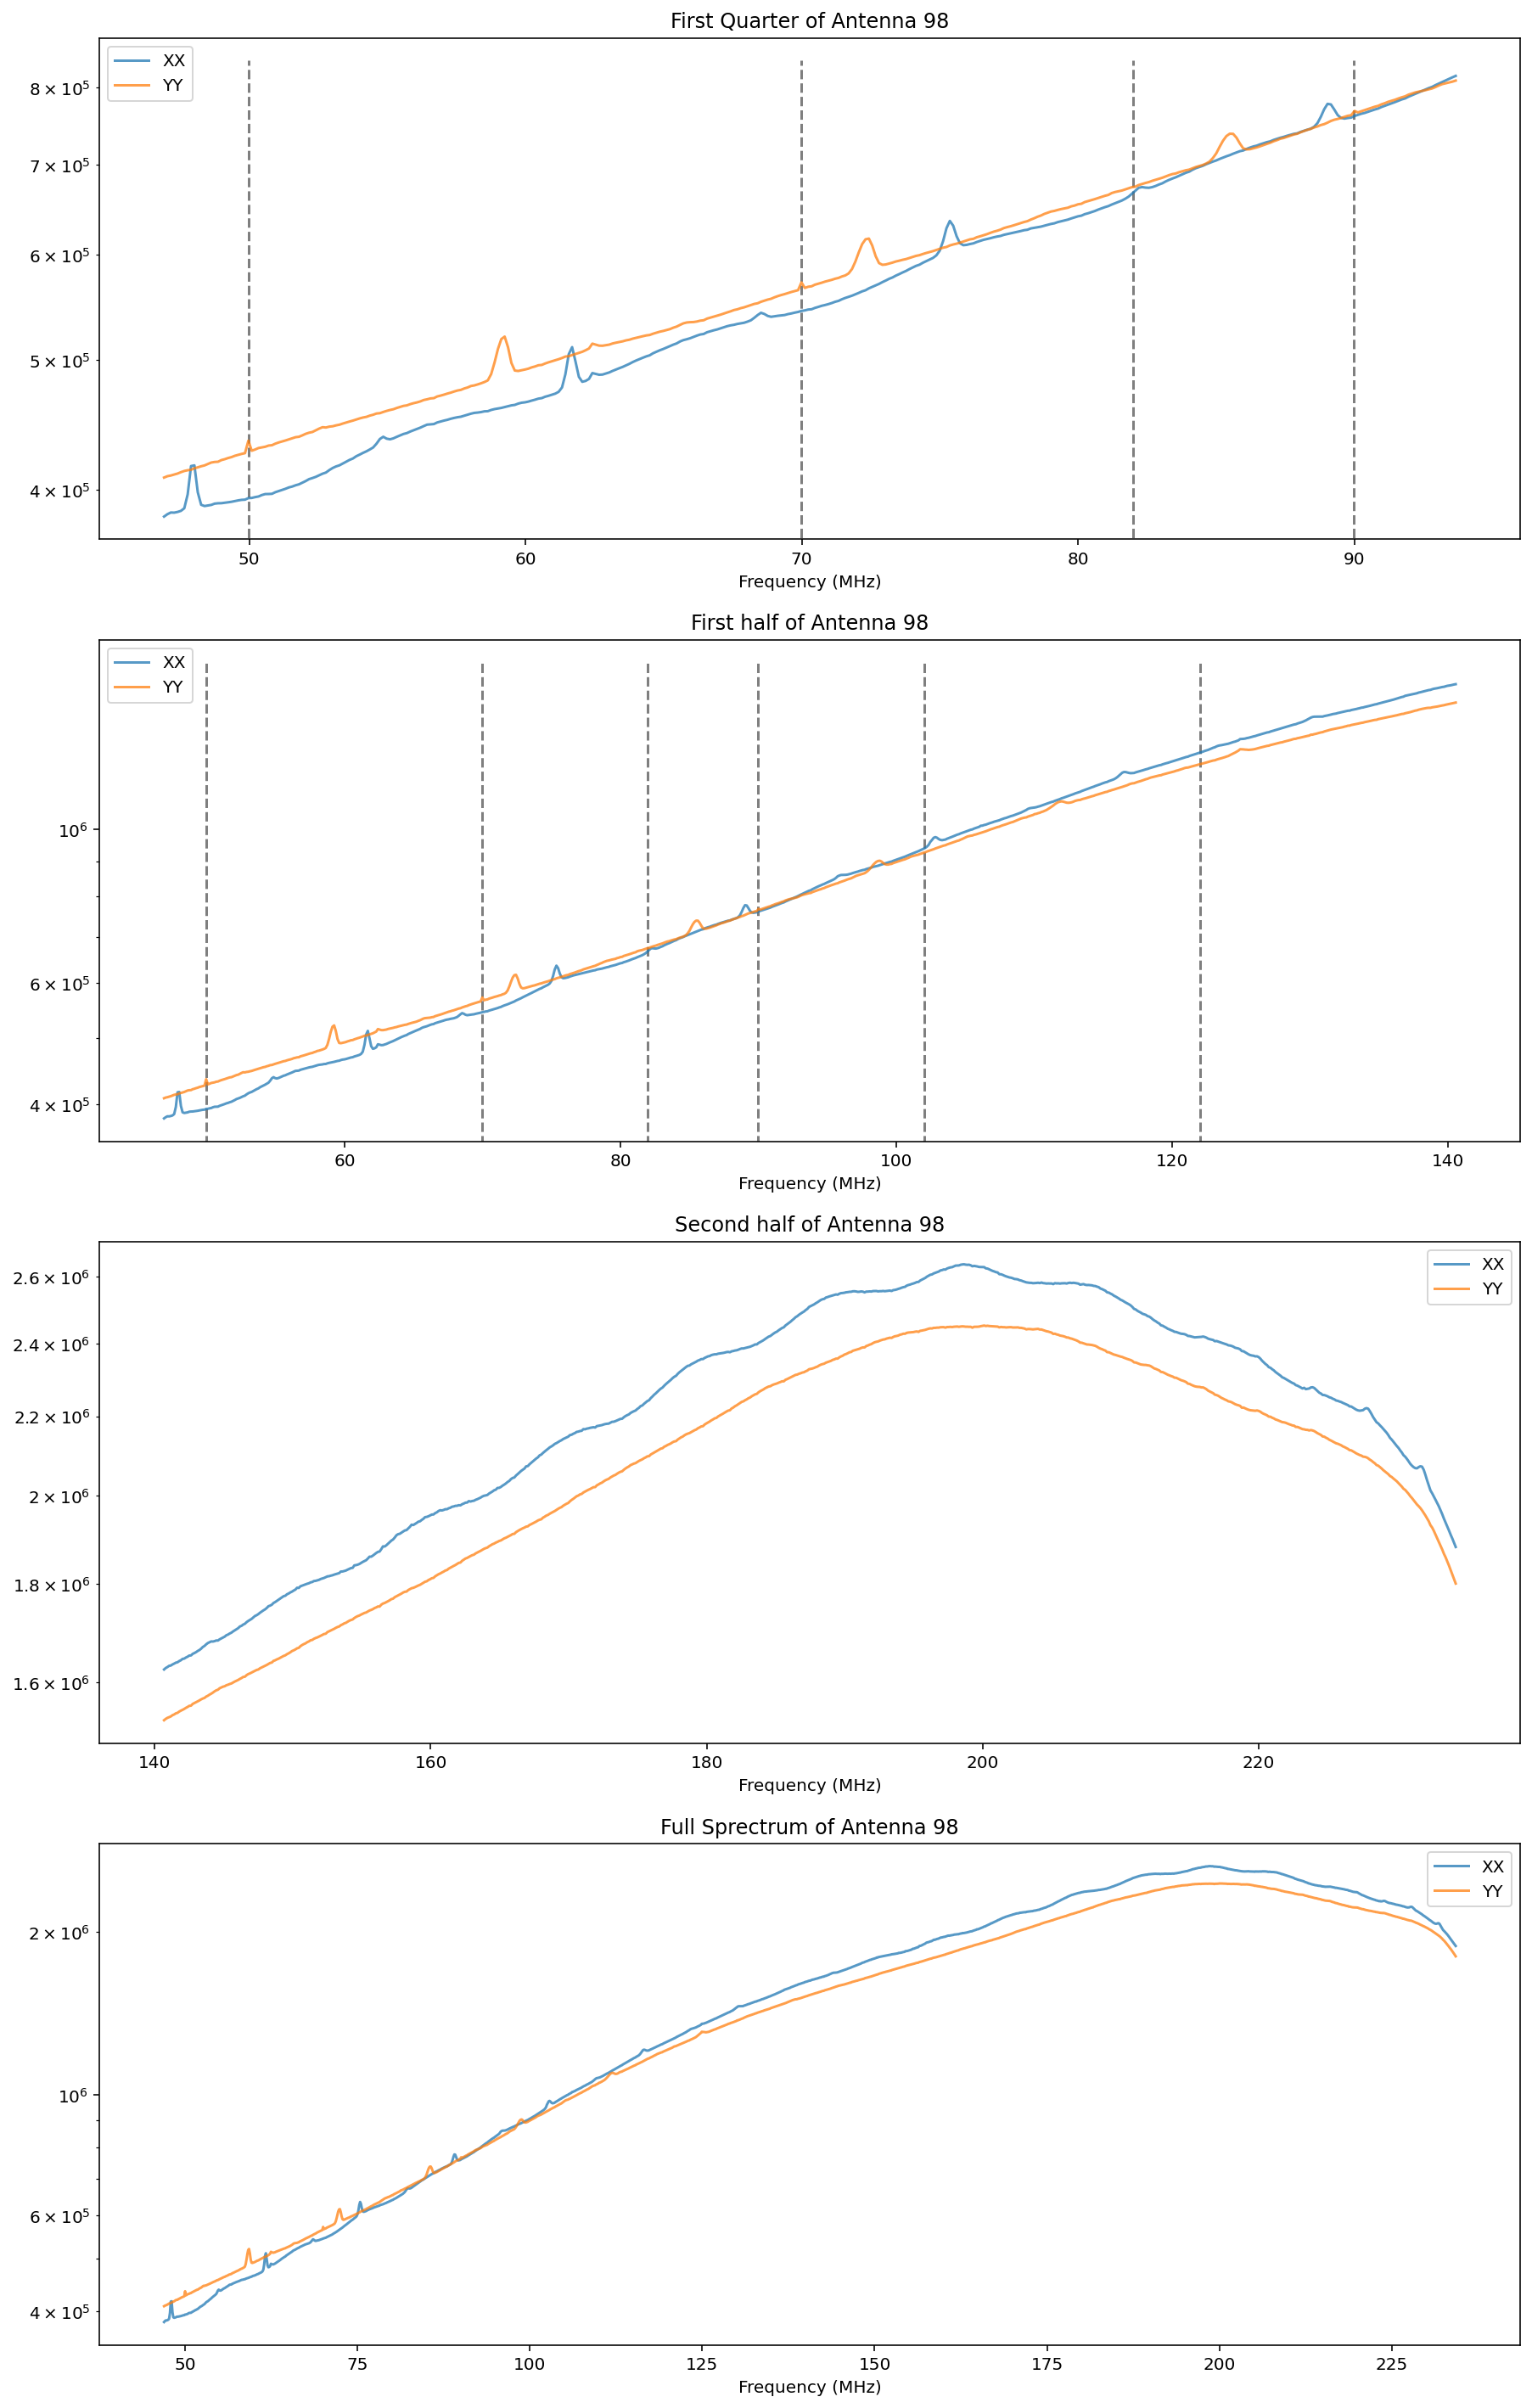

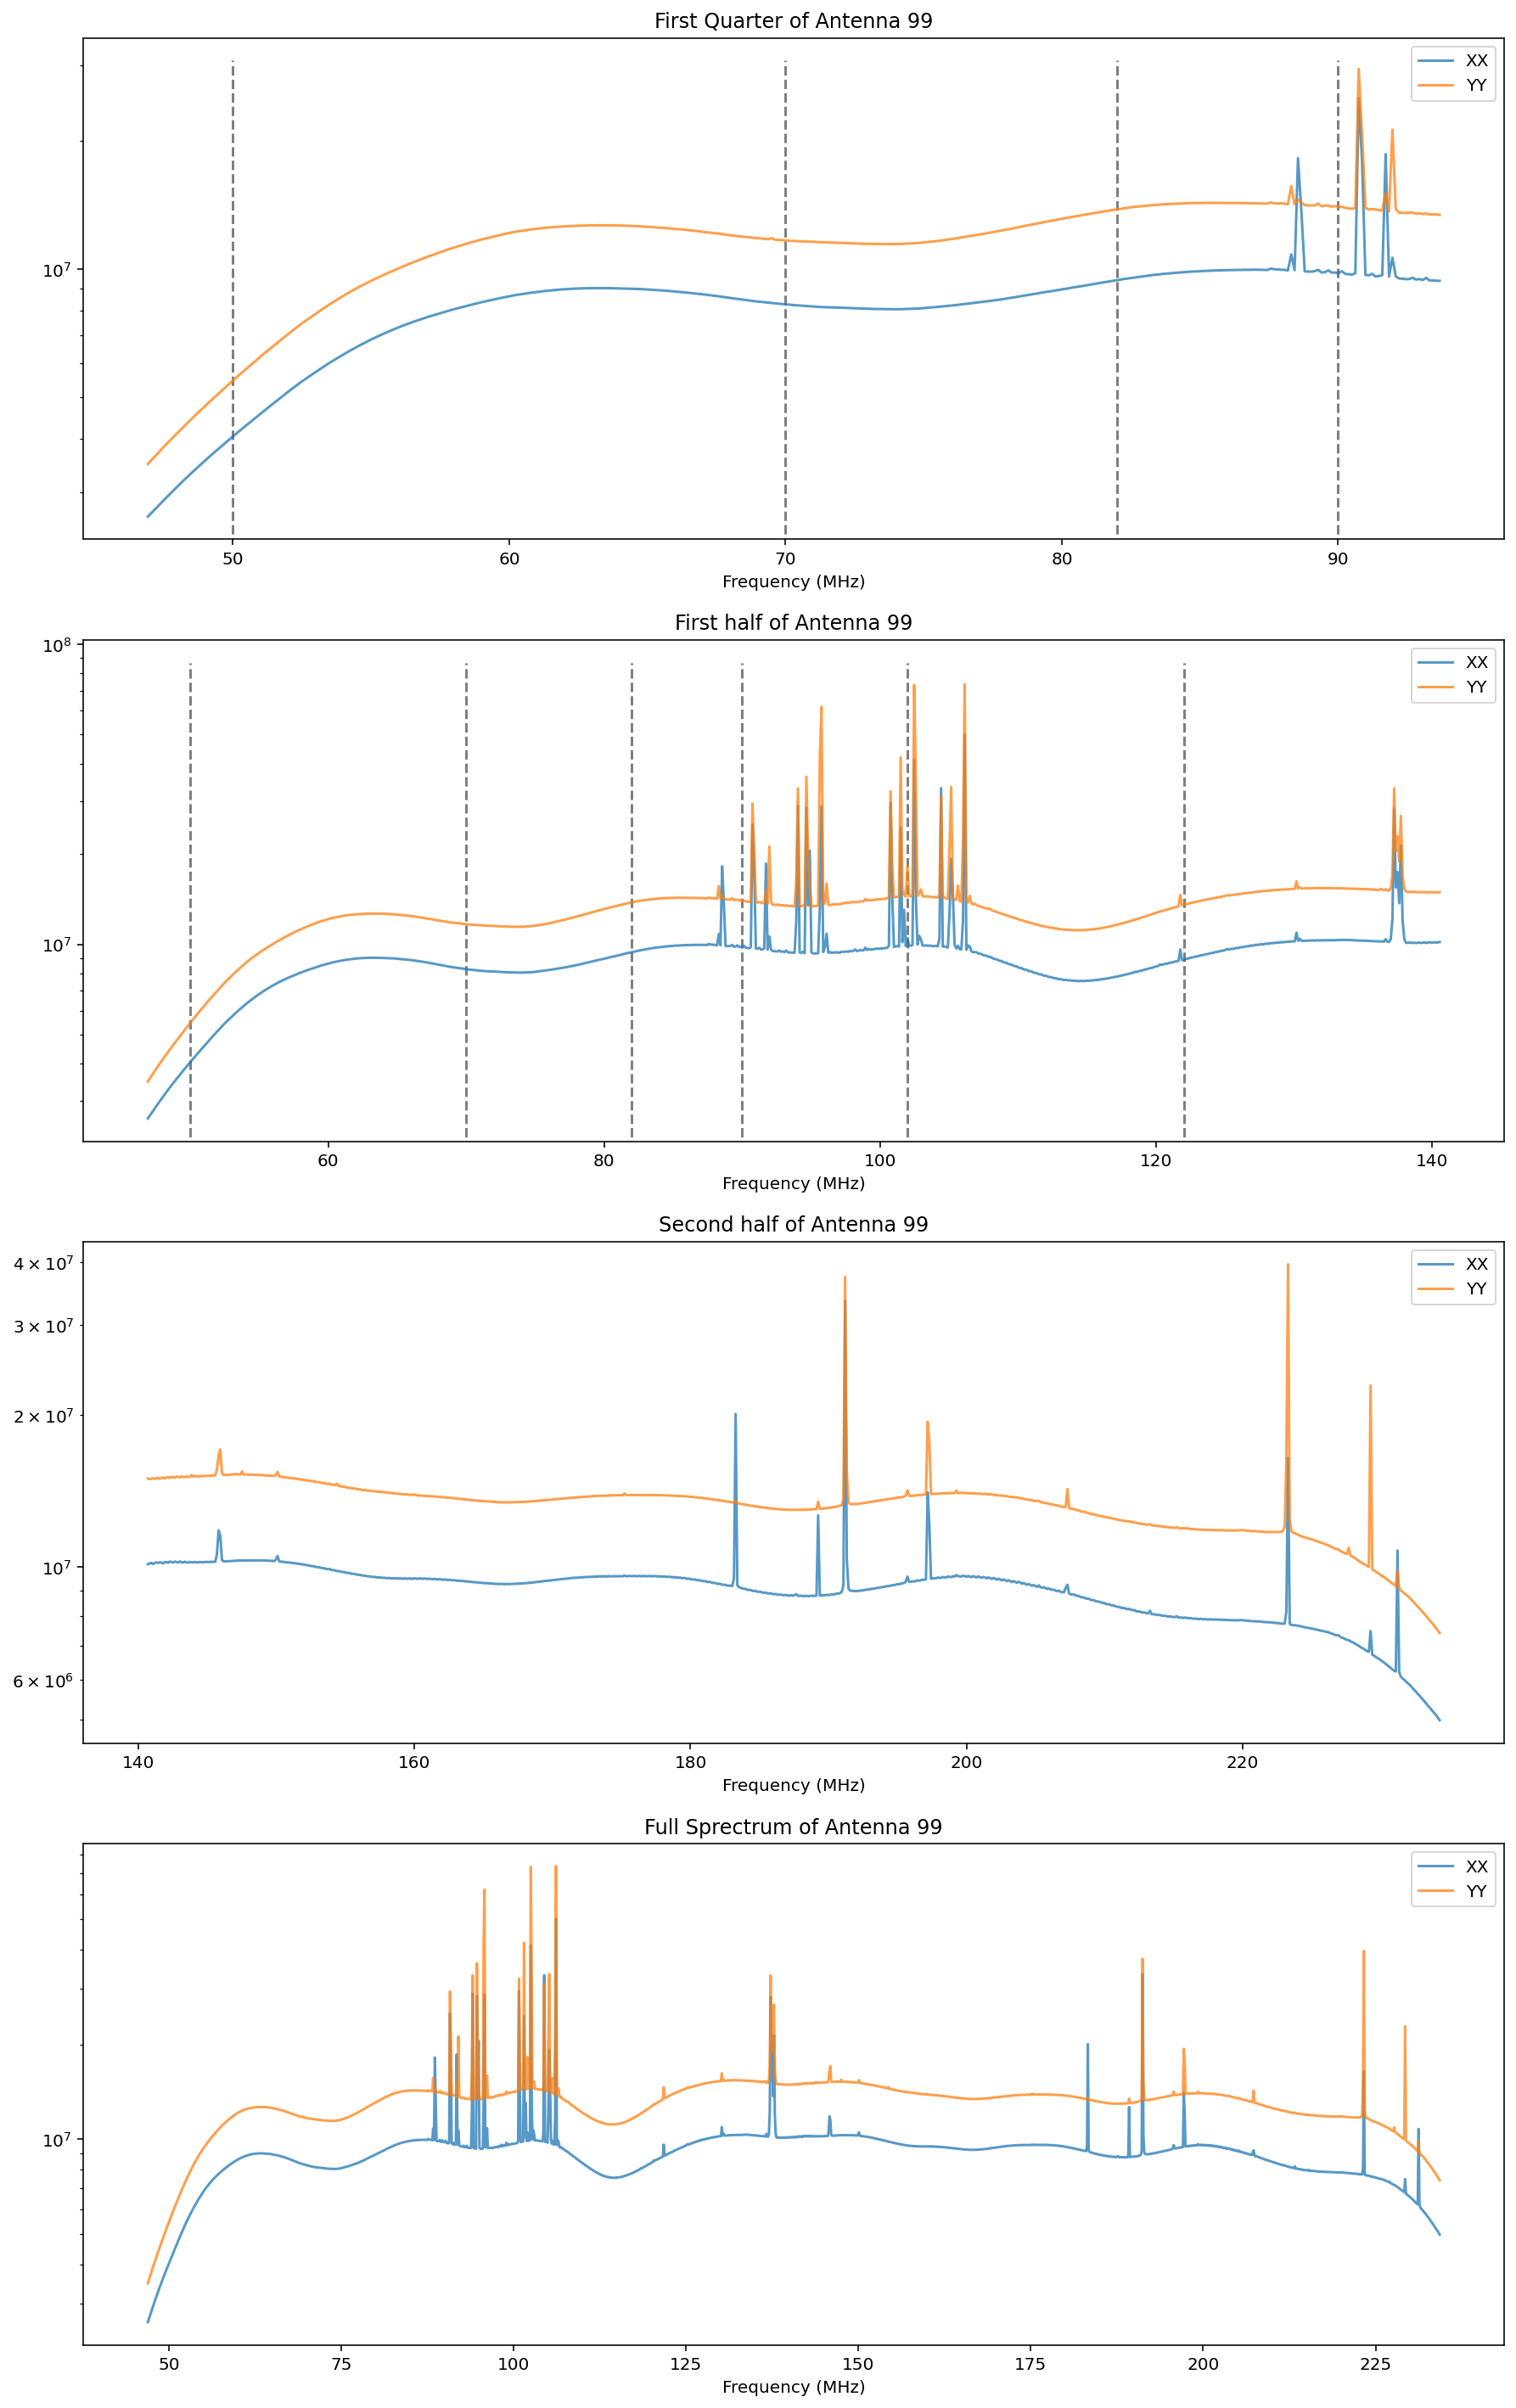

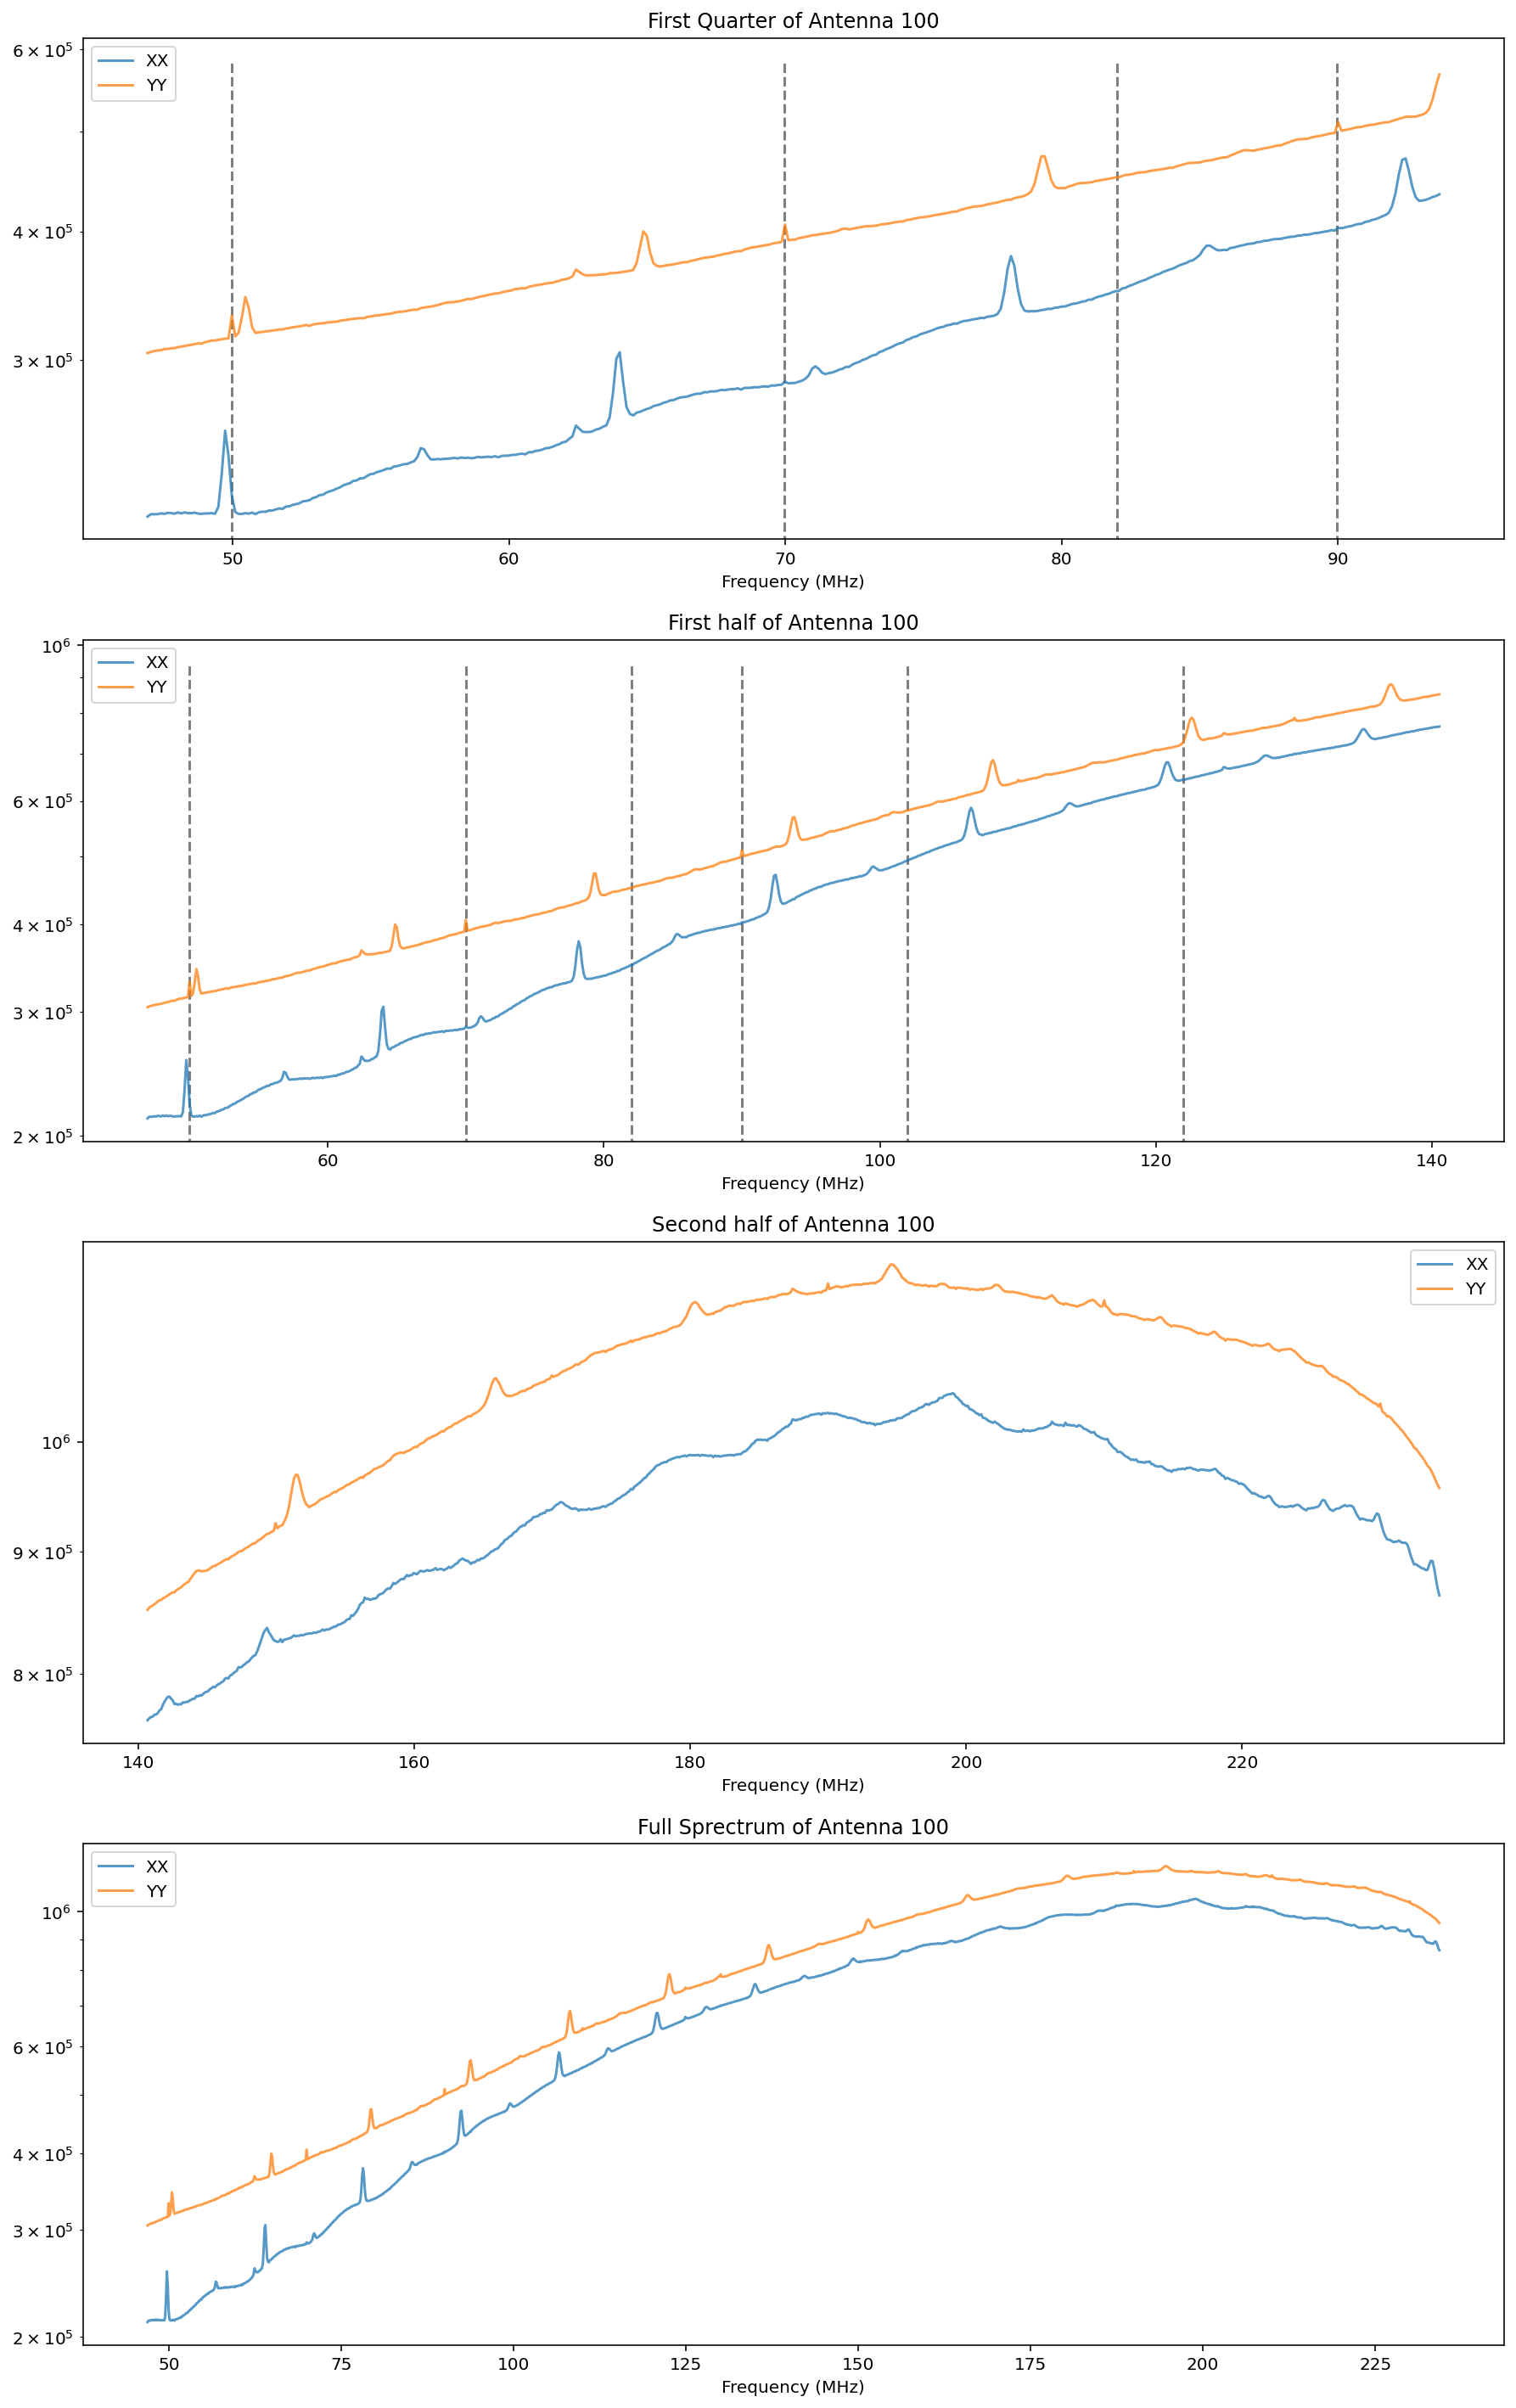

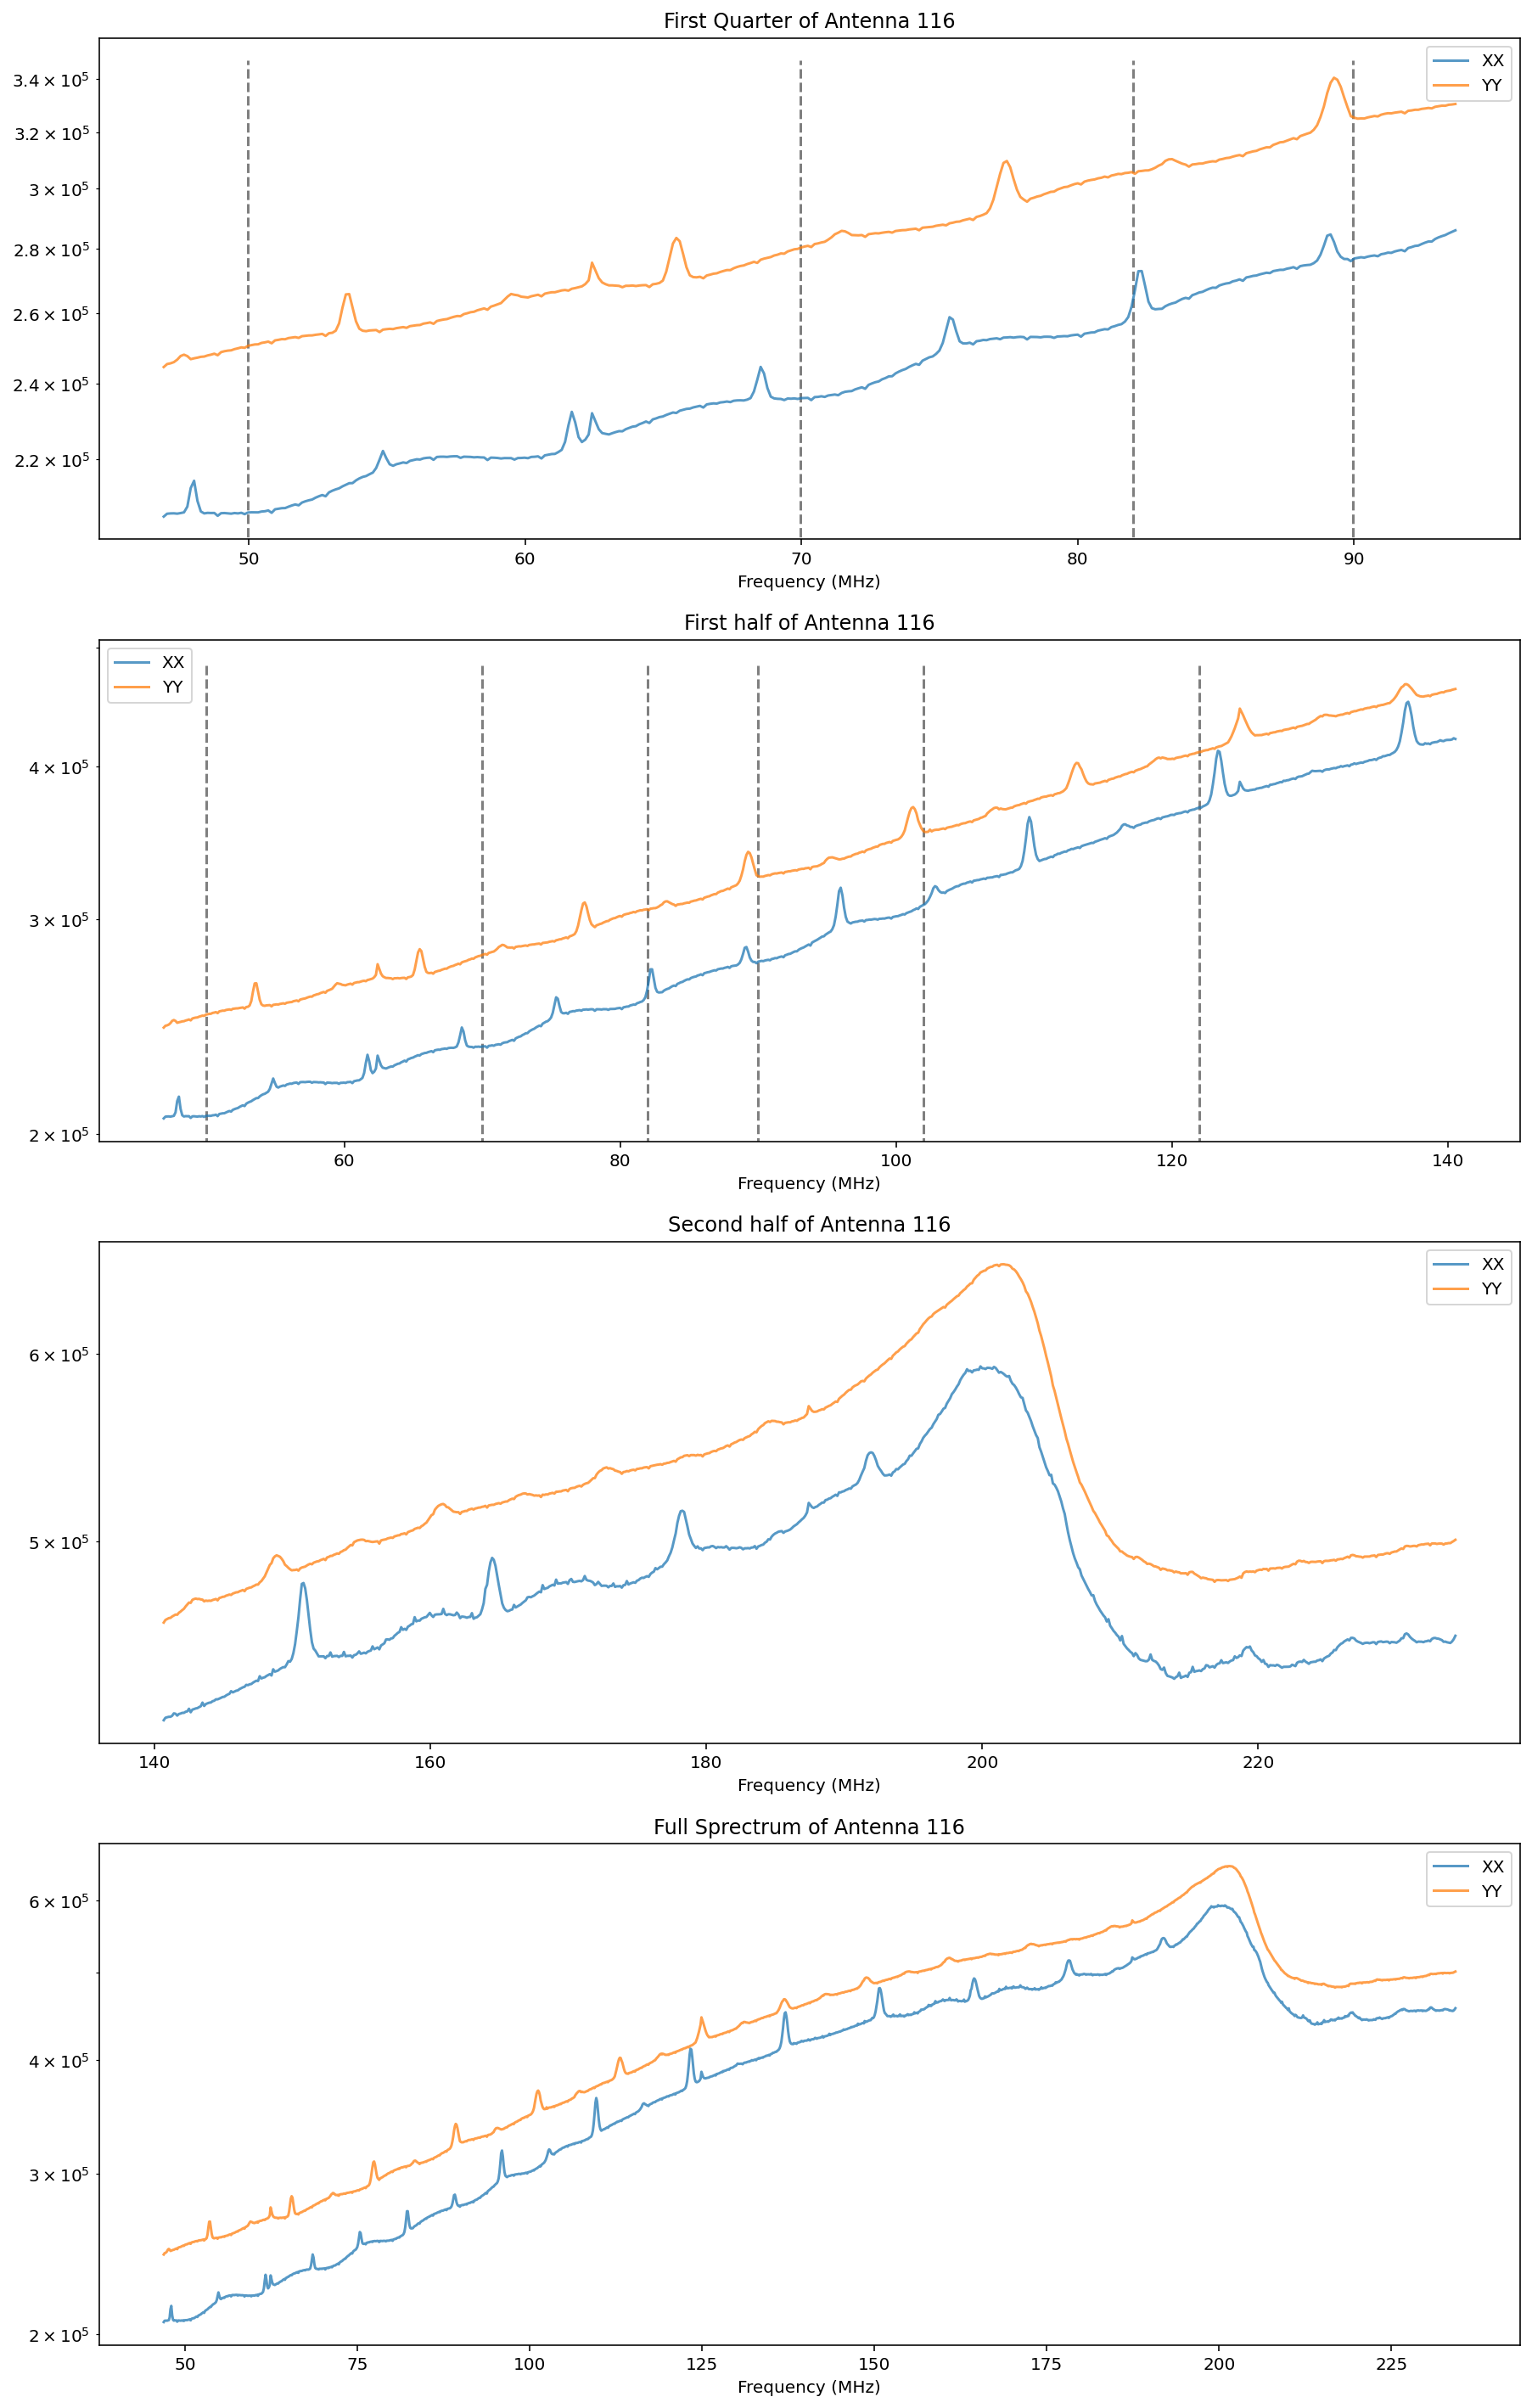

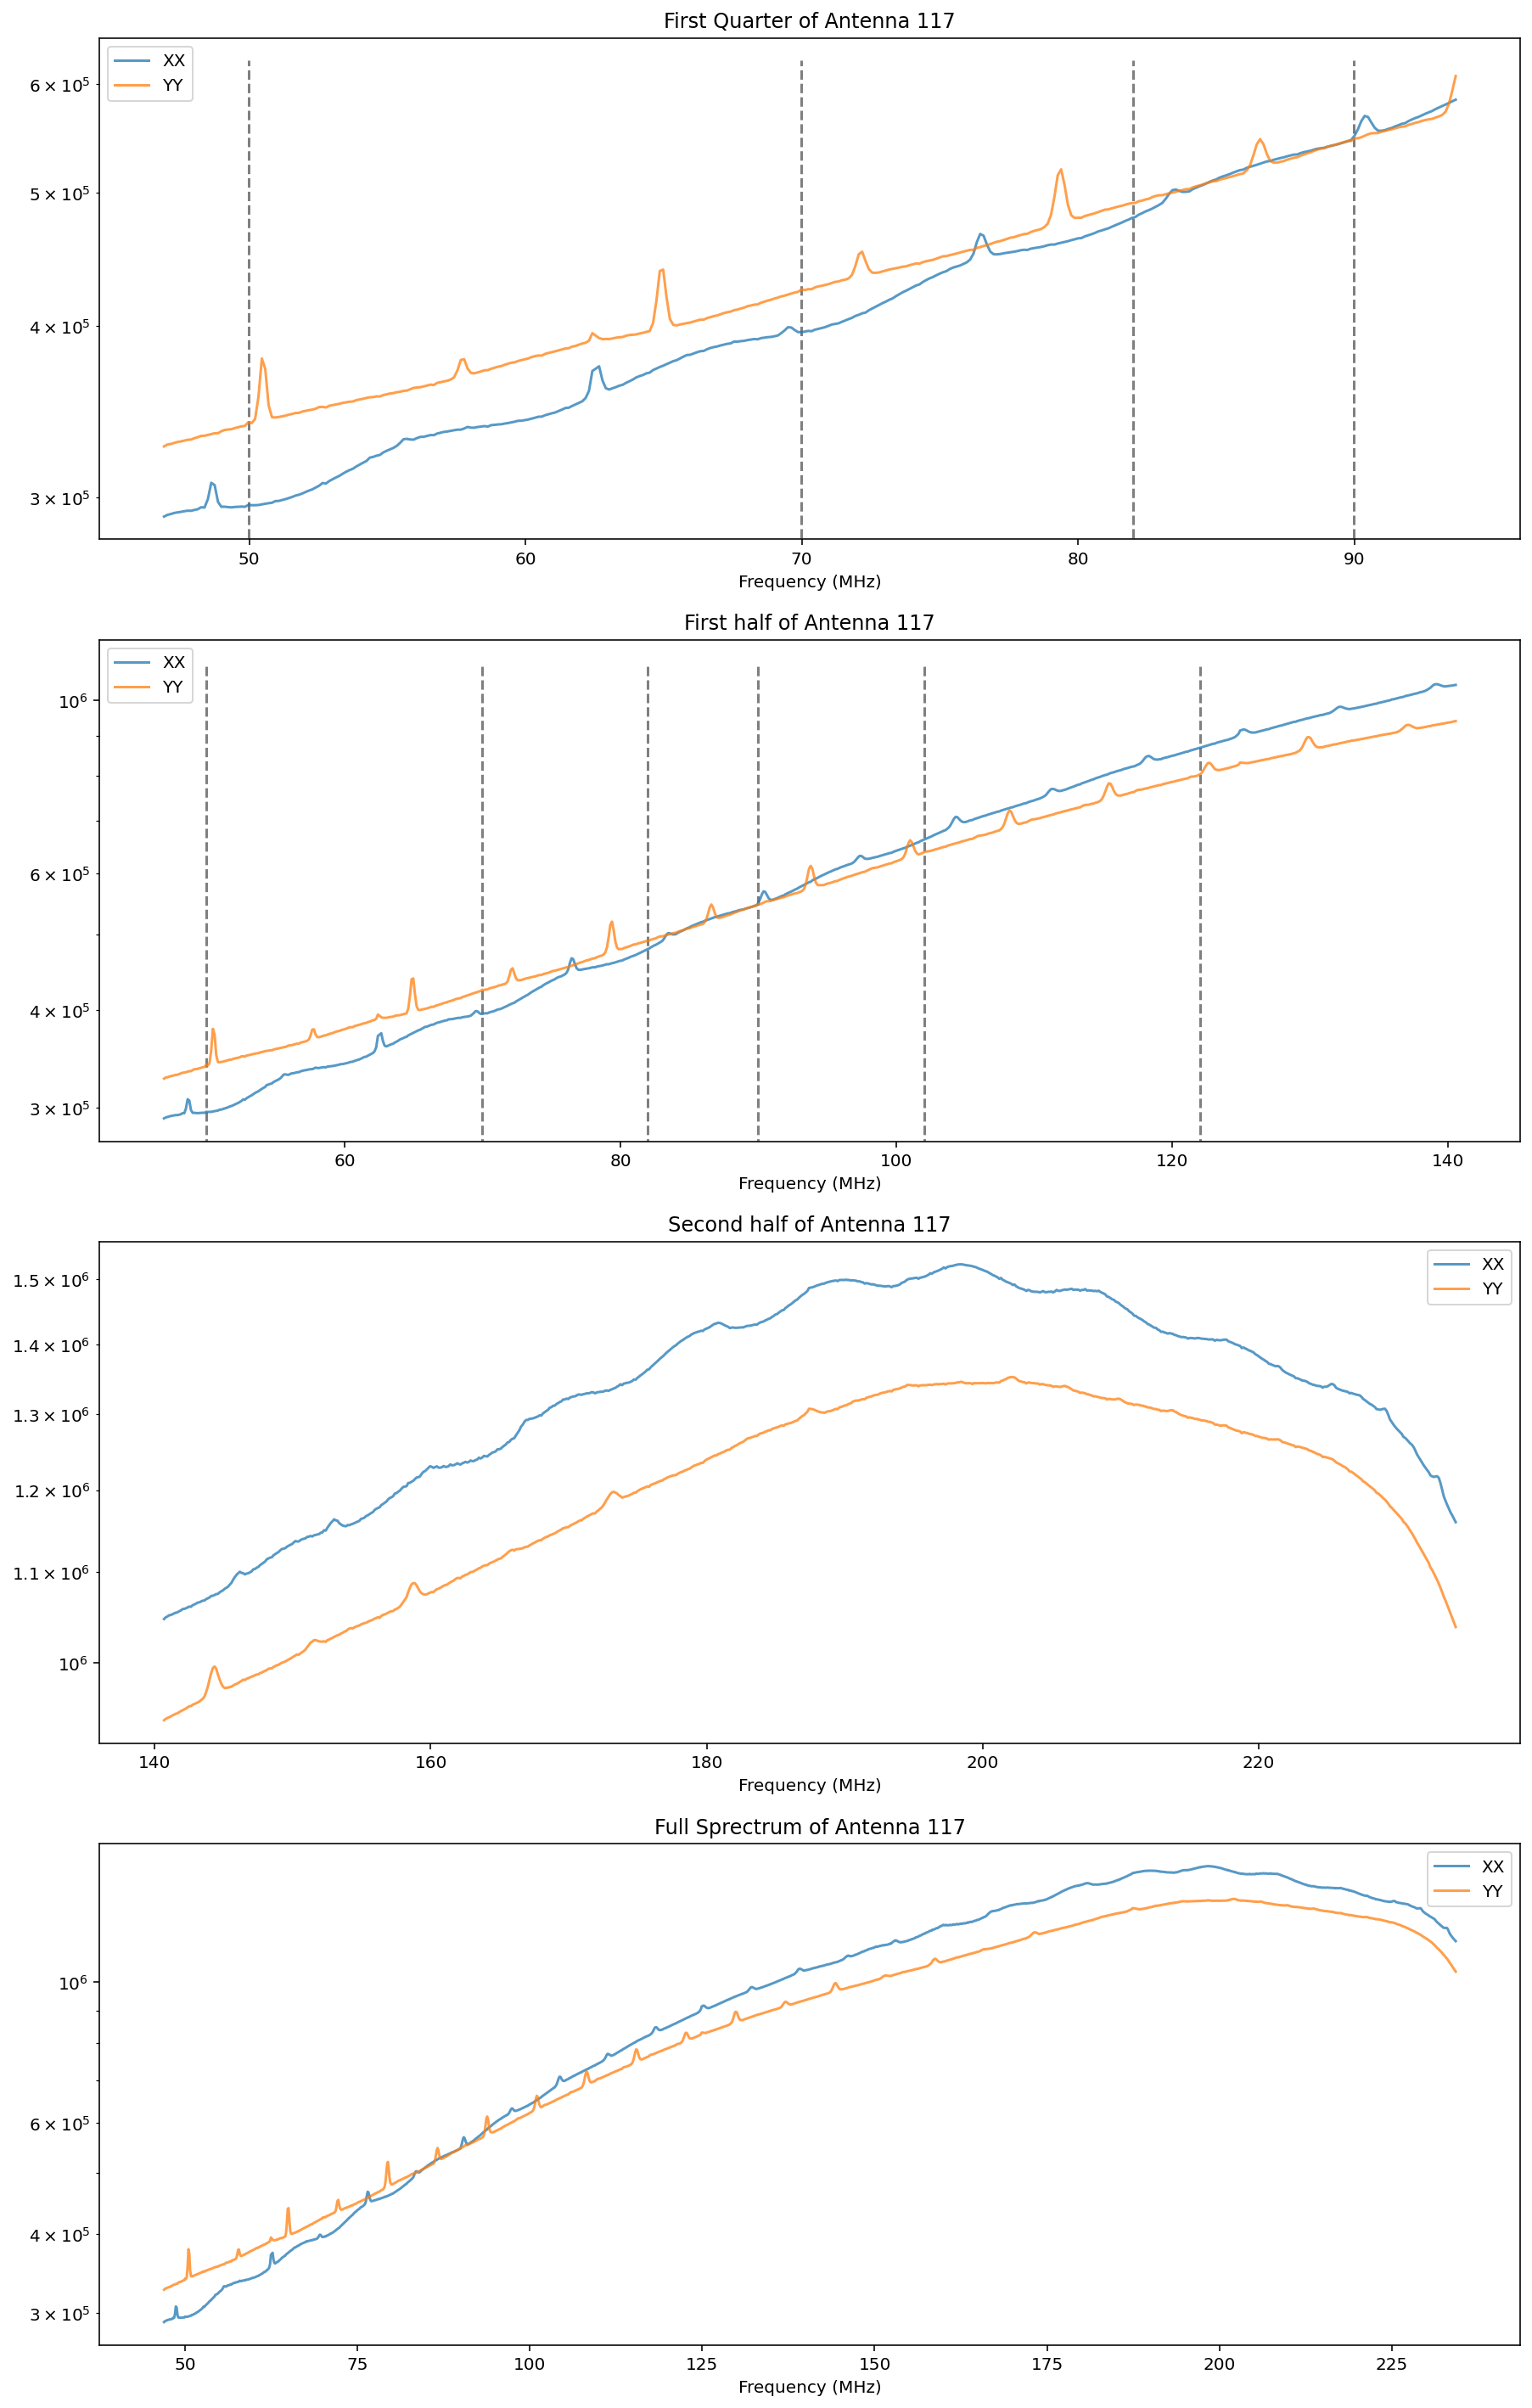

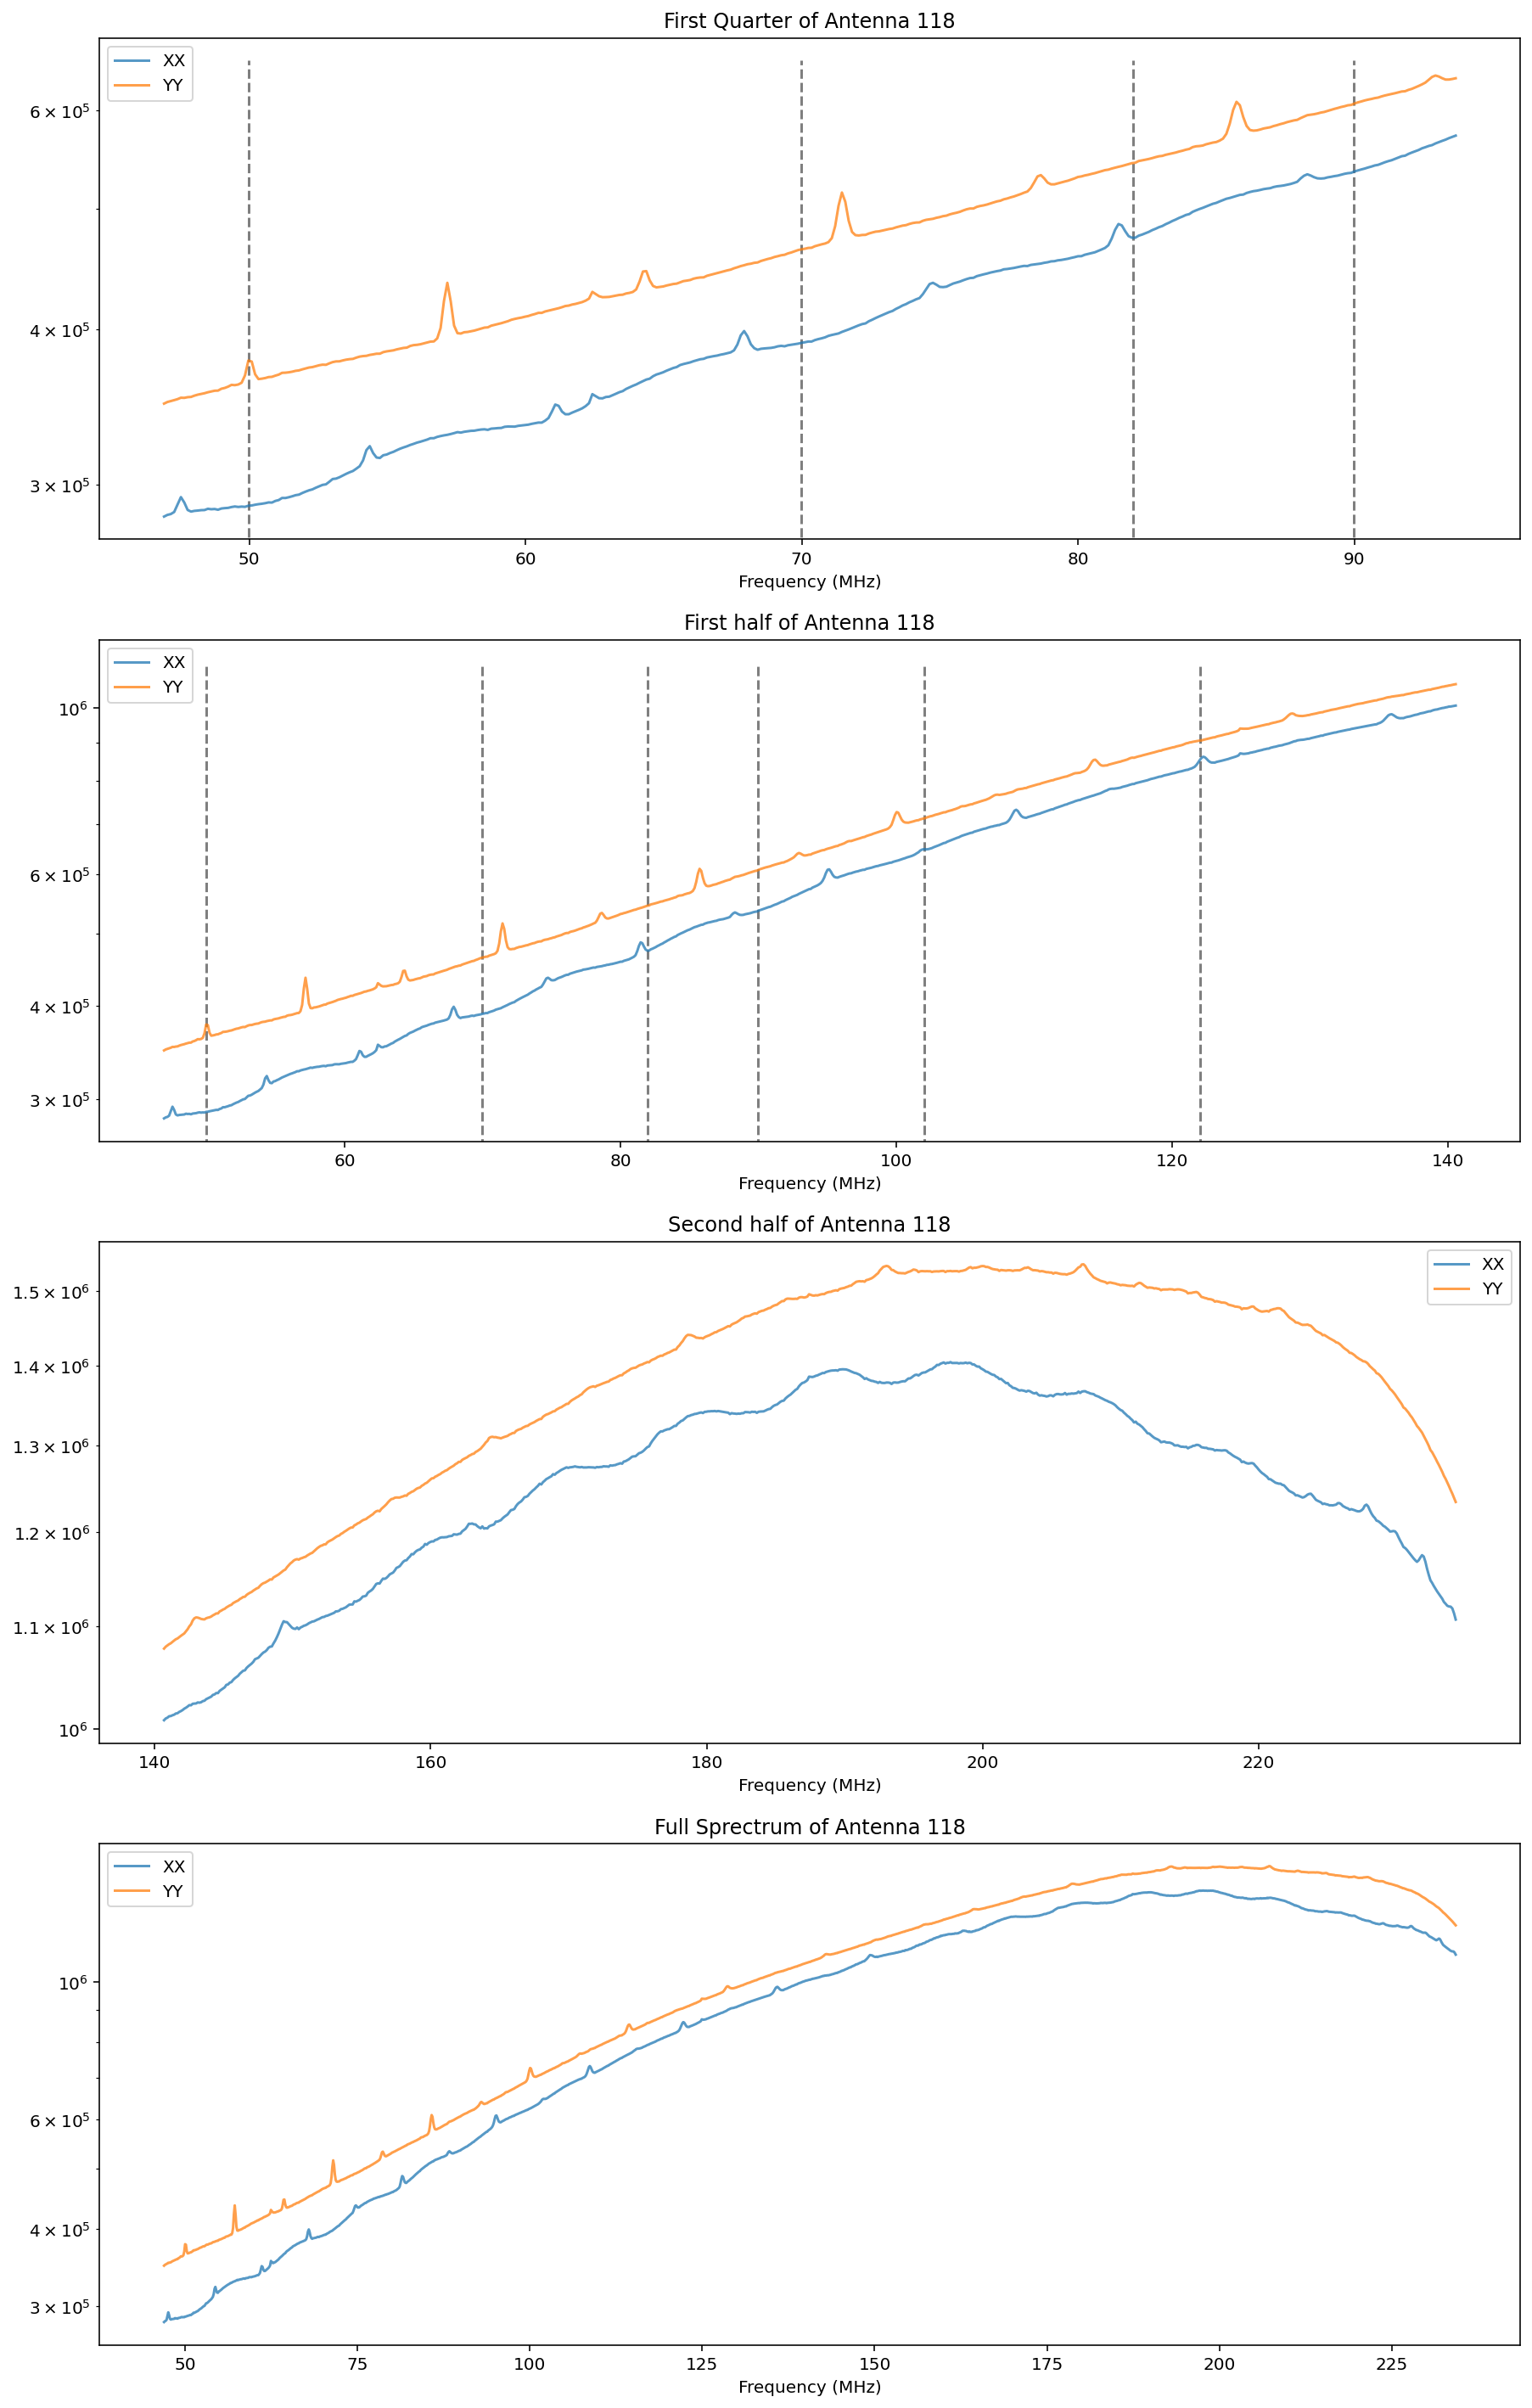

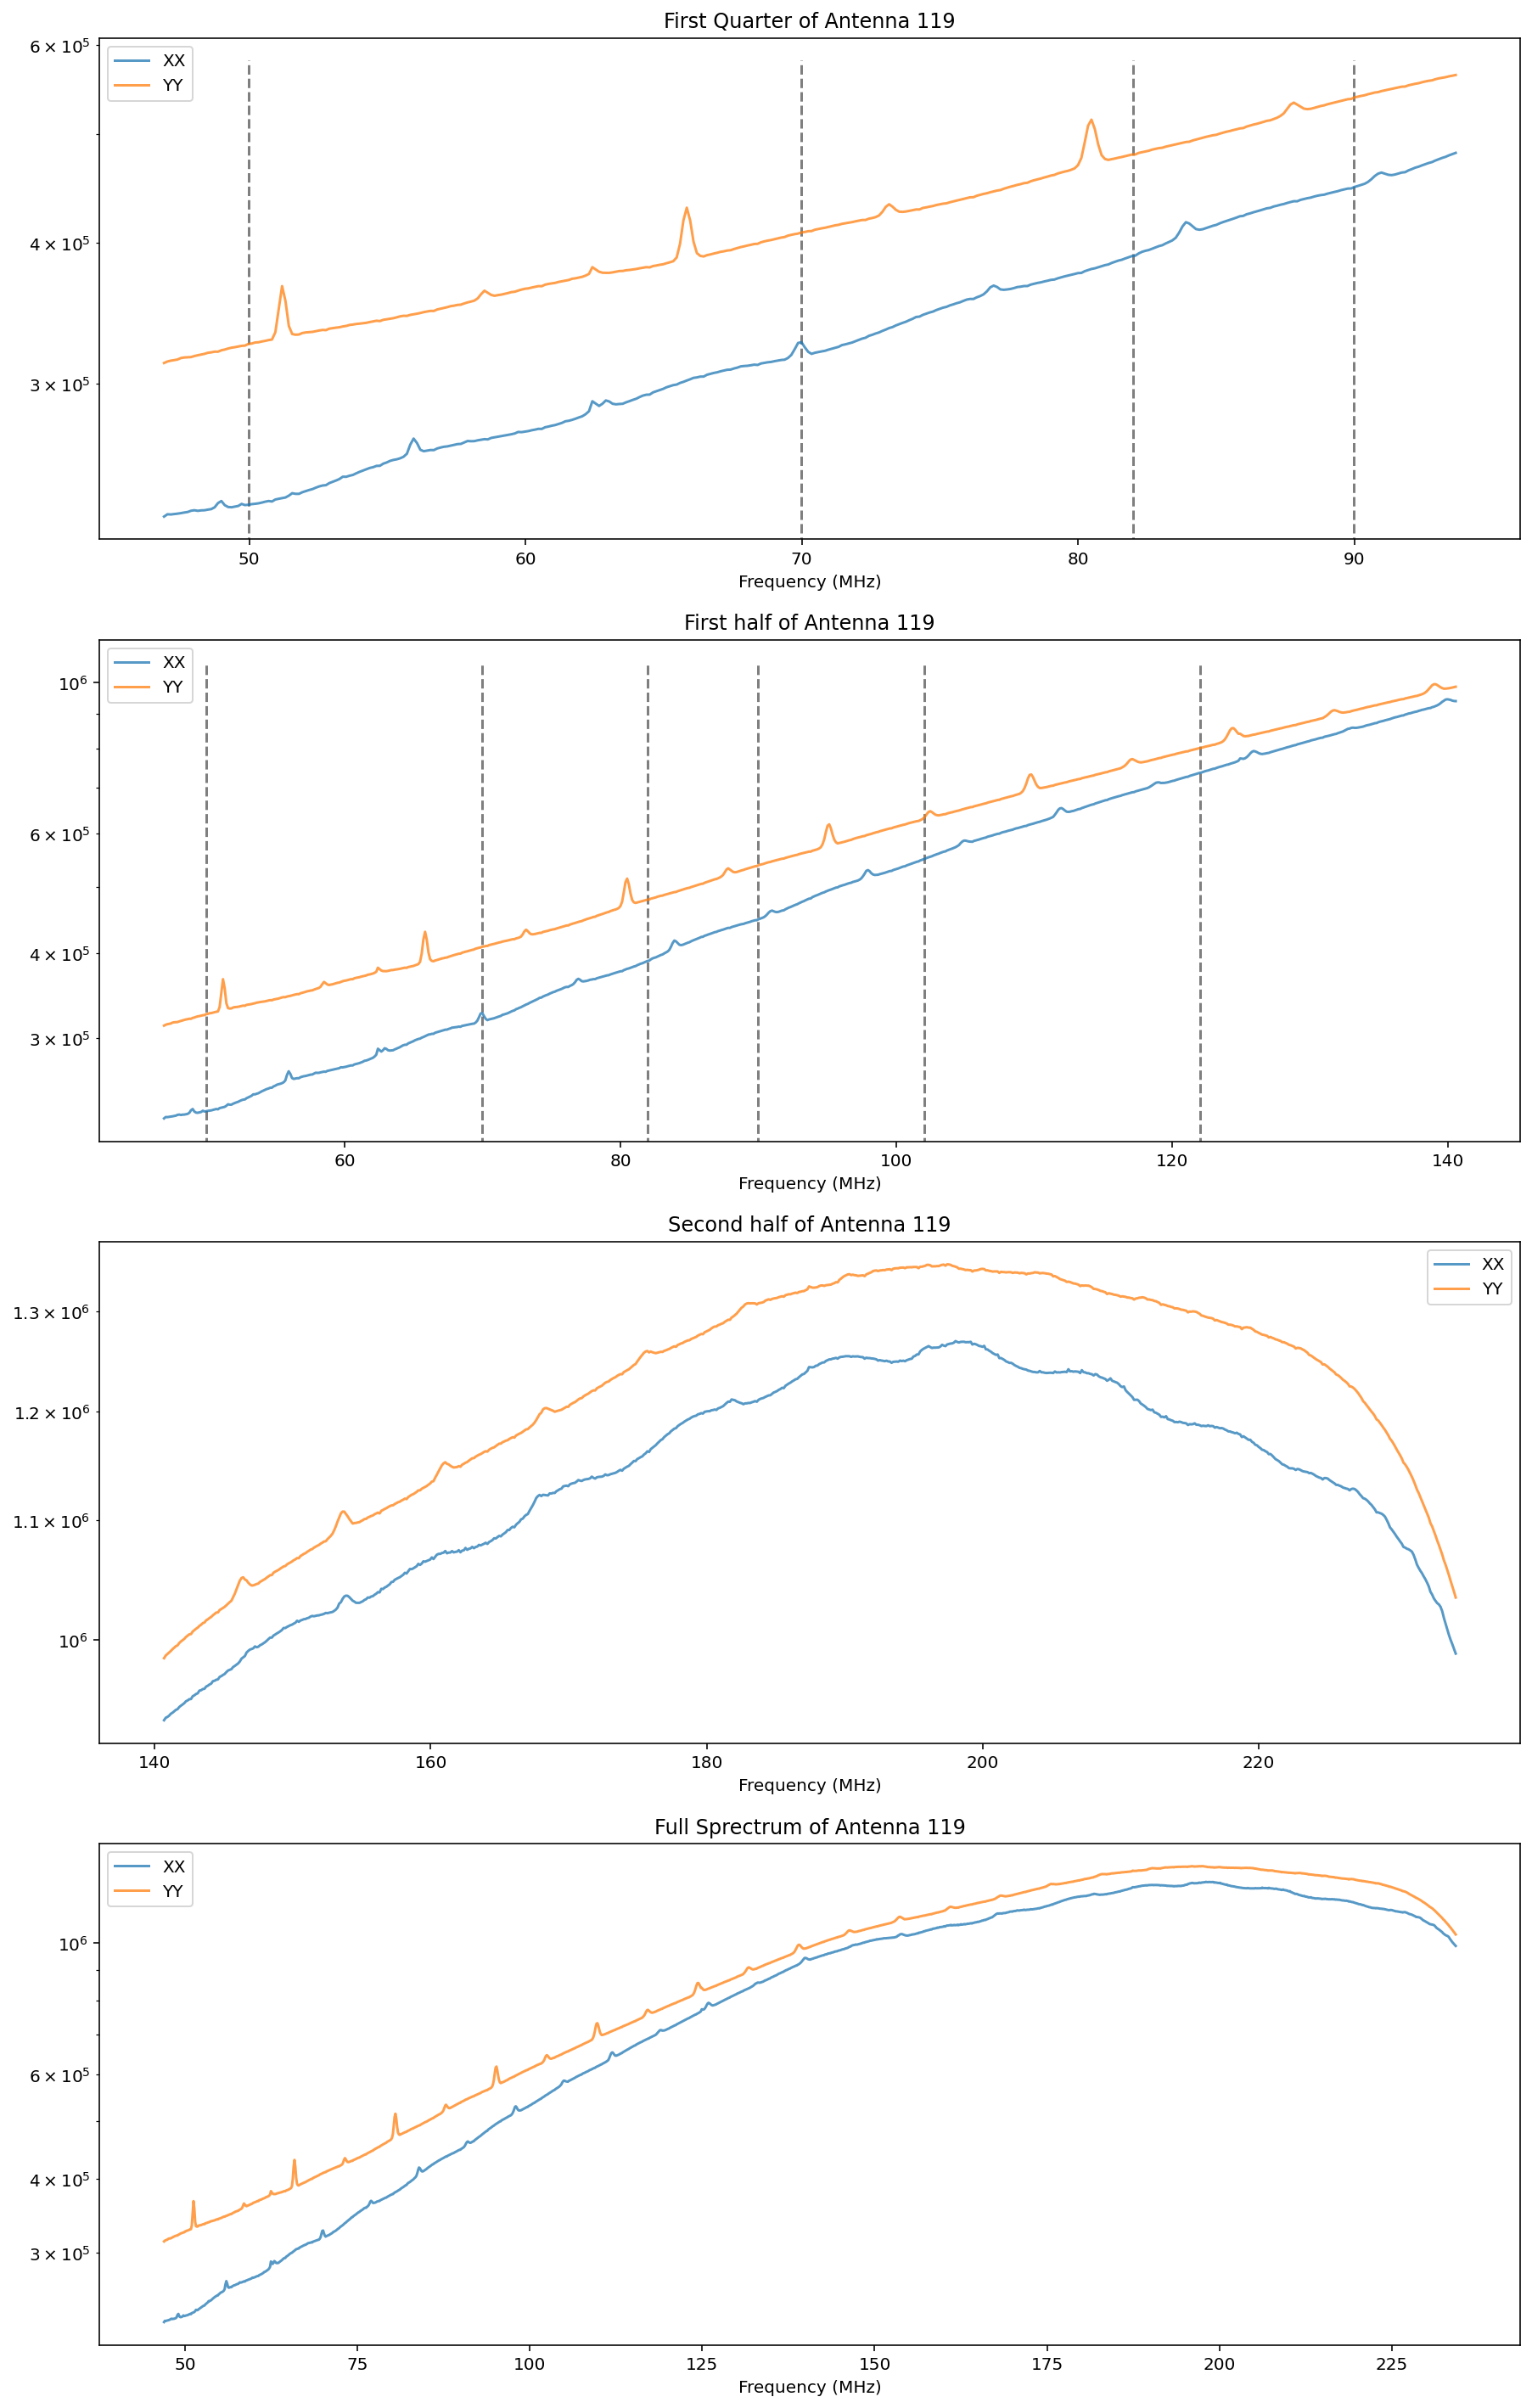

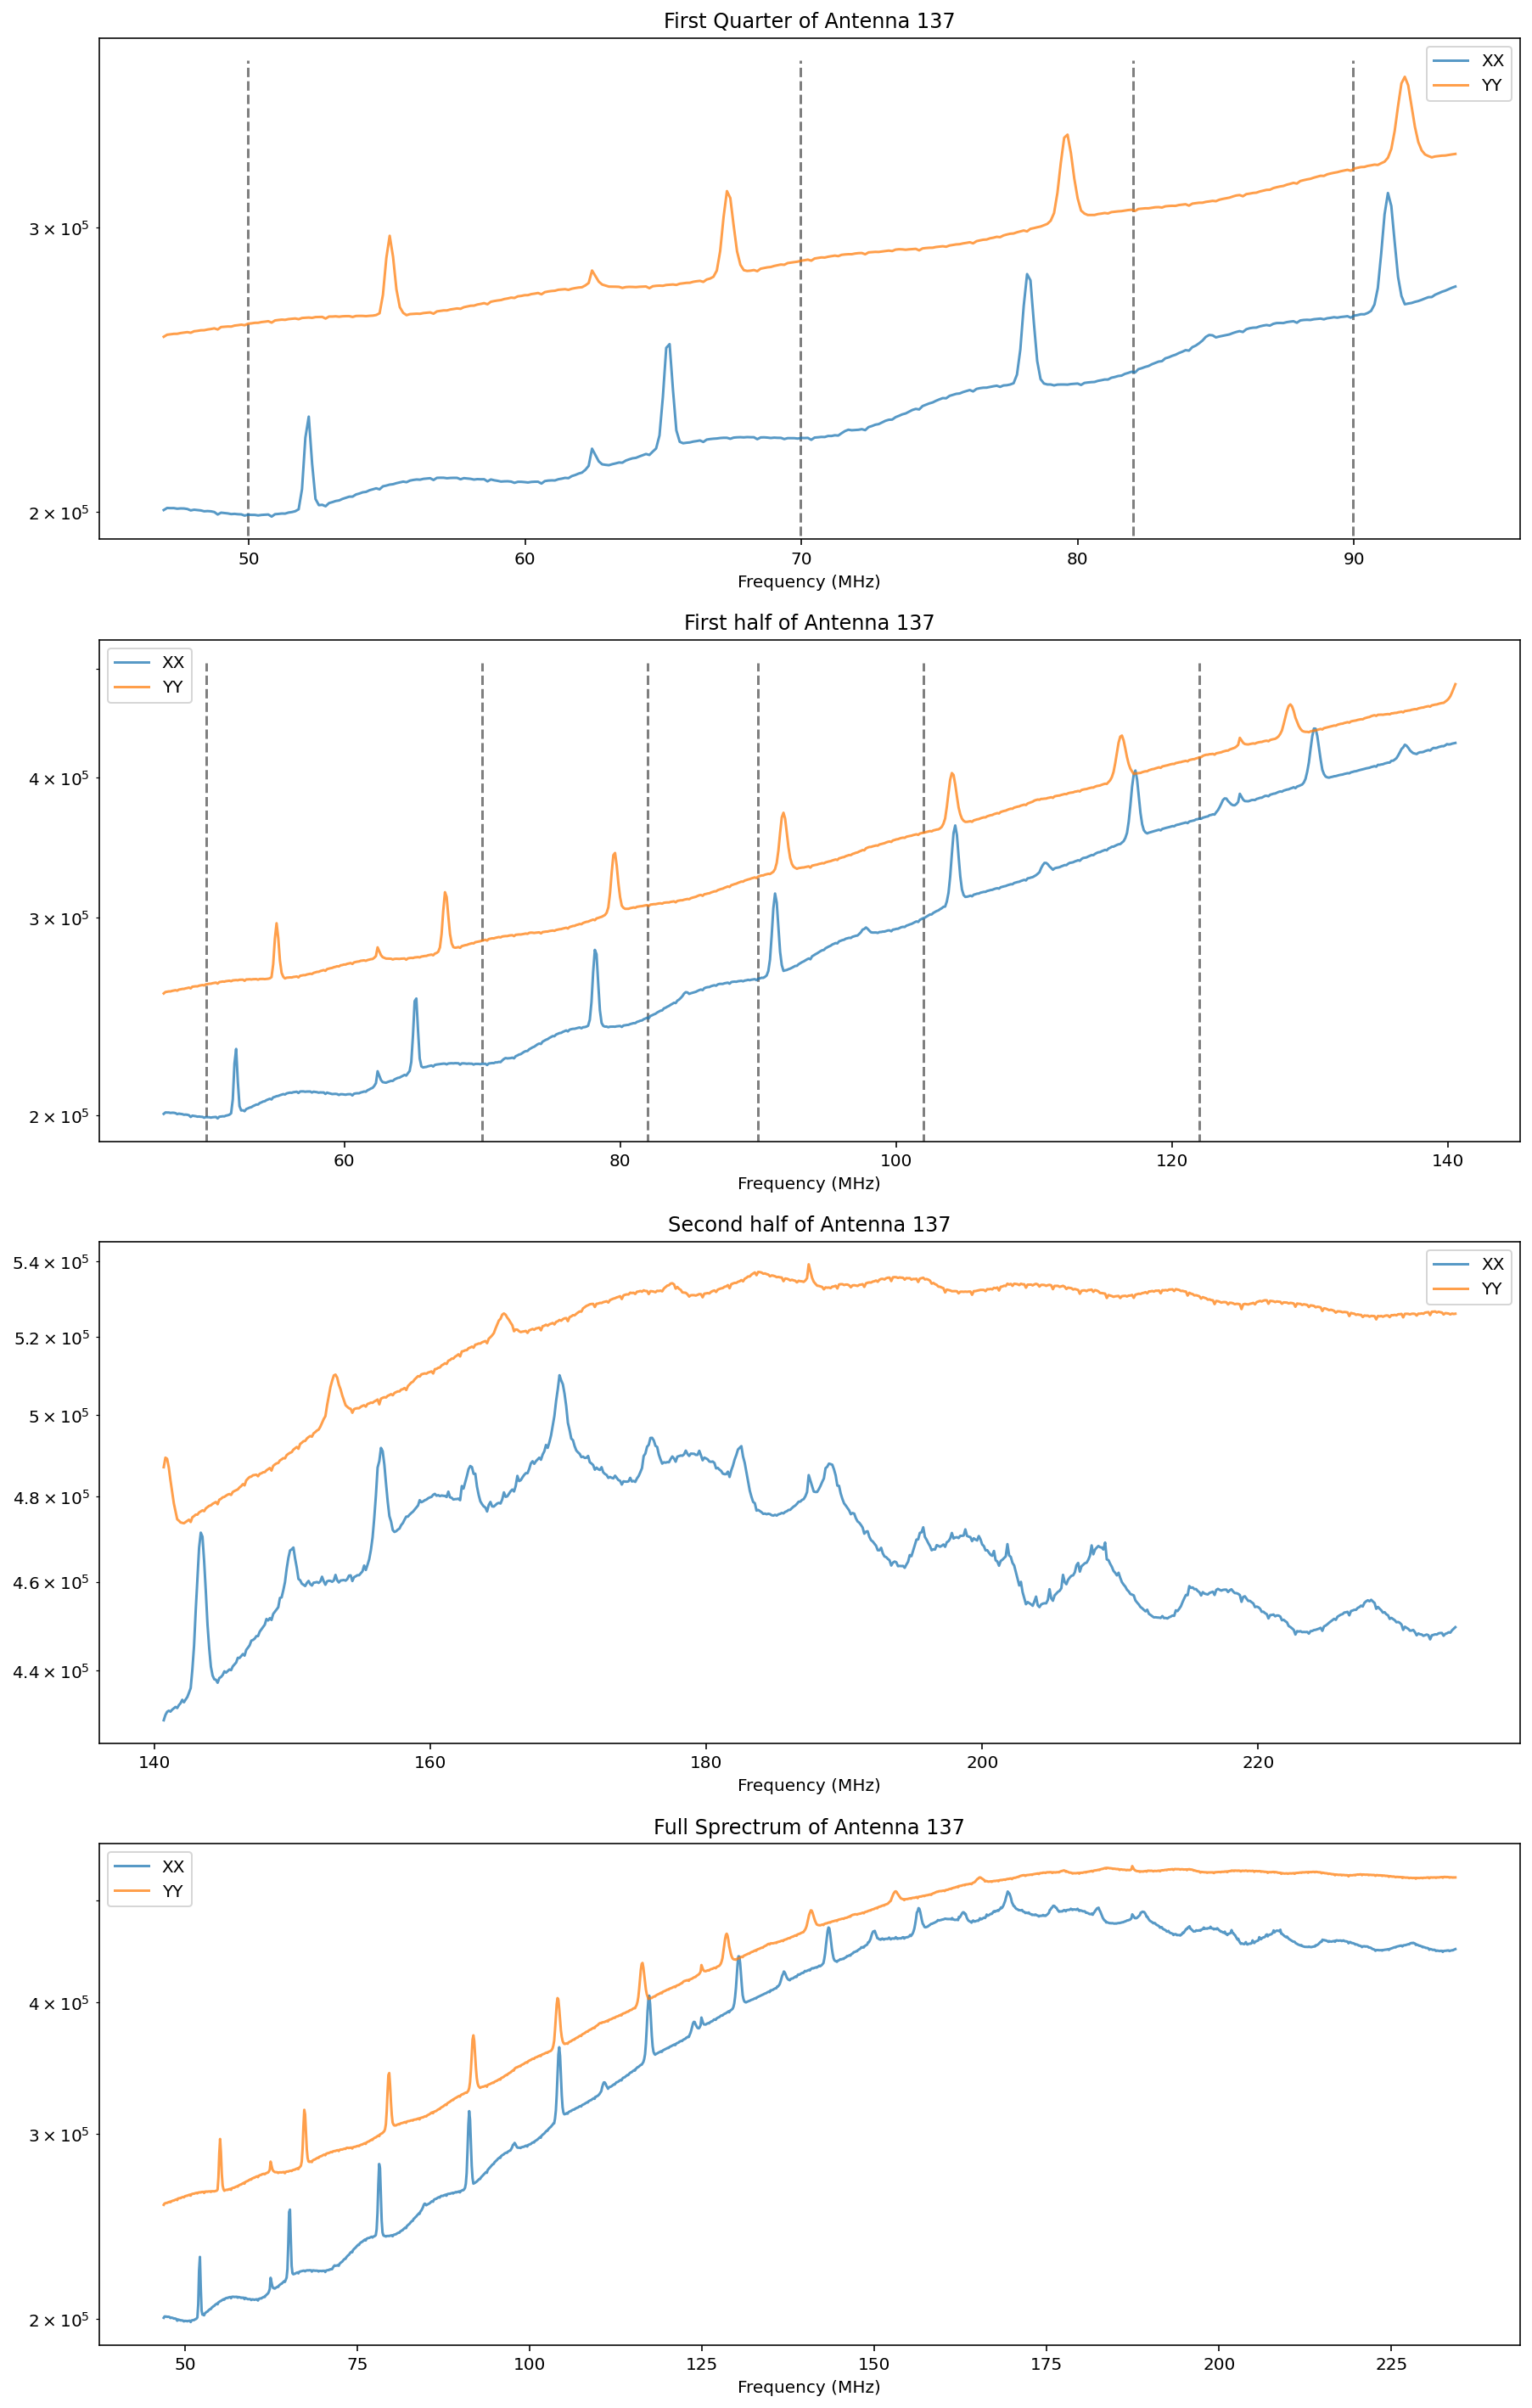

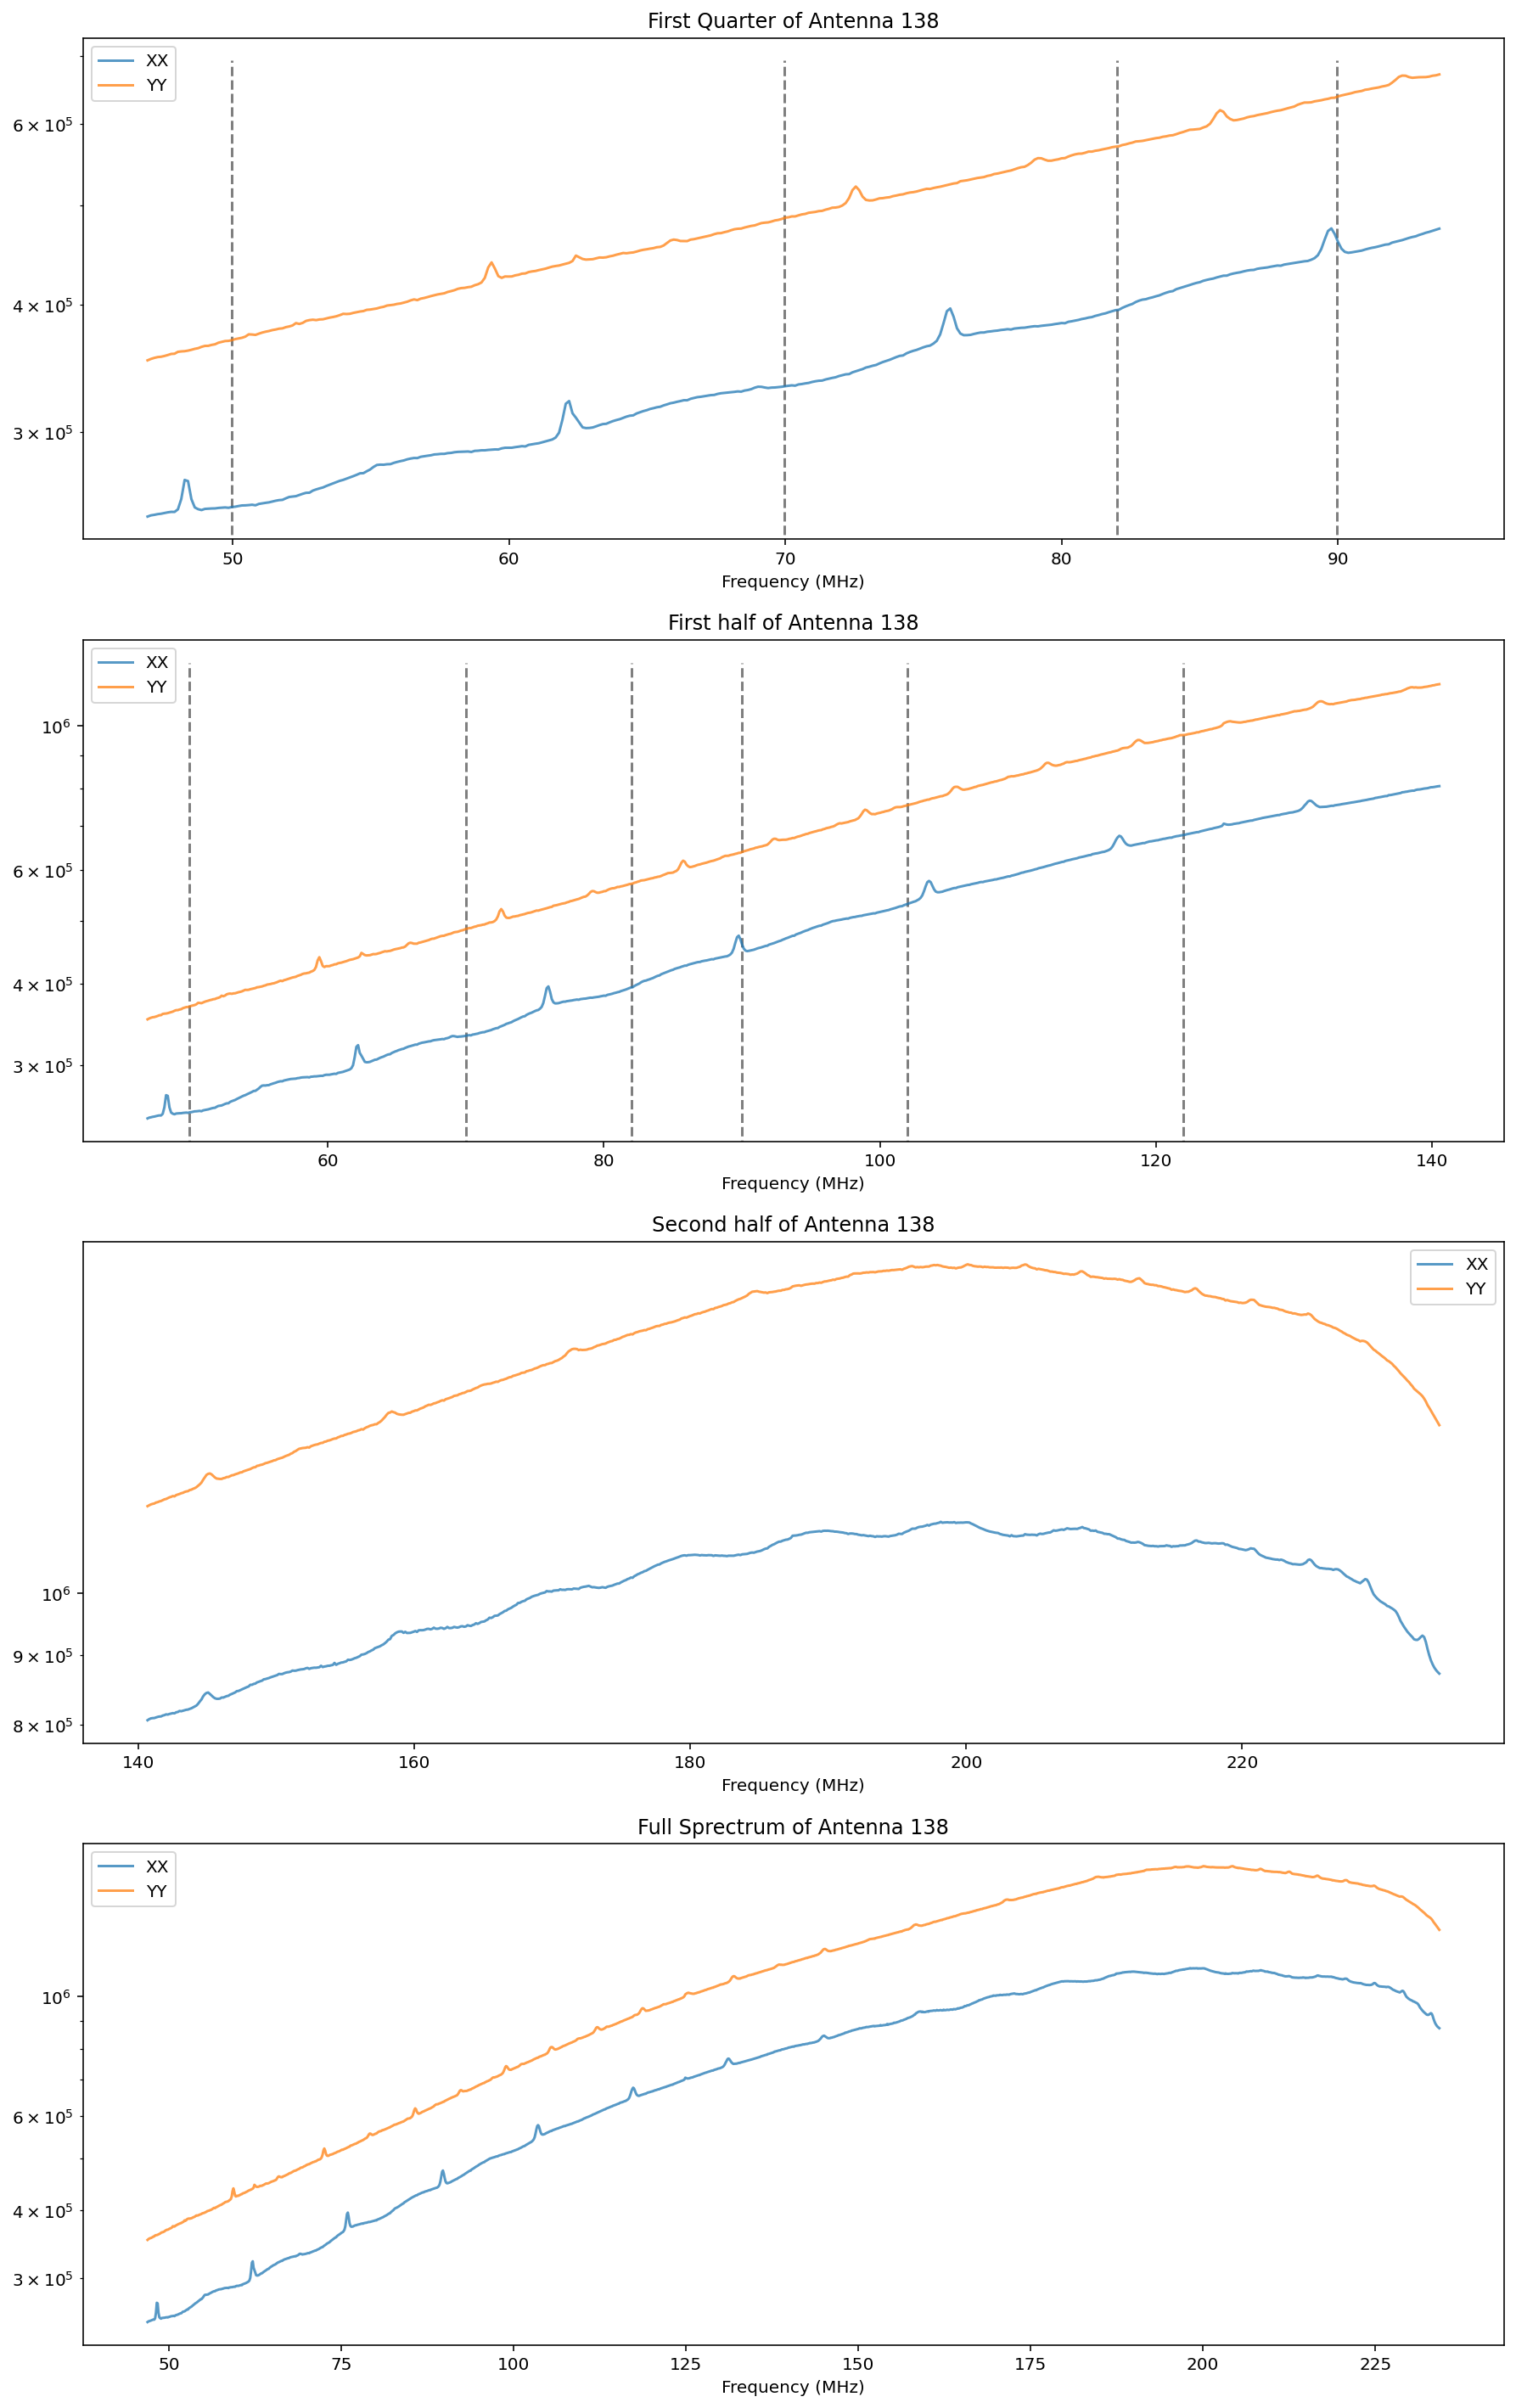

In [10]:
plot_node(2459144,"/lustre/aoc/projects/hera/lberkhou/","07")

In [25]:
out, _ = (
    ffmpeg
    .input('in.mp4')
    .output('pipe:', format='rawvideo', pix_fmt='rgb24')
    .run(capture_stdout=True)
)
video = (
    np
    .frombuffer(out, np.uint8)
    .reshape([-1, height, width, 3])
)

NameError: name 'ffmpeg' is not defined